# CURSO DATA SCIENCE DIGITAL HOUSE

# WORKSHOP II: Análisis de Regresión Lineal (Caso Properatti)

## Grupo 3 - Integrantes

- D'HUTEAU, Yann F
- MESA, Andrés
- HERNANDEZ, Adrián
- CORBATTO, Mauricio D

## Introducción


Para este trabajo se pretende implementar un estudio para la empresa inmobiliaria Properati con el fin de predecir el precio por metro cuadrado de una propiedad desarrollando modelos de regresión con la ayuda de herramientas analíticas(habiendo limpiado previamente el dataset original propuesto en el WS I).


<a id="section_toc"></a> 
## Tabla de Contenido


[1. Importar librerías](#section_importar_libreria)

[2. Dataset](#section_dataset)

[3. Detección de valores faltantes - Borrado de Columnas](#section_deteccion_faltantes)

[4. Exploración inicial de precios](#section_explorar_precios)

[5. Modelo Base de Regresión Lineal](#section_modelo_base)

[6. Agregando variables categóricas al modelo](#section_agregando_var_cat)

[7. Trabajos de limpieza y transformación sobre los datos](#section_limpieza_y_transformacion)

[8. Haciendo Cross Validation de los diferentes modelos](#section_cross_validation)

[9. Regresión lineal para el modelo obtenido - Resumen de resultados (ARG)](#section_resumen_resultados)

[10. Regresión lineal para el modelo obtenido - Resumen de resultados (CABA)](#section_resumen_resultados_caba)


[11. Análisis de Consistencia del Modelo. Supuestos de Markov](#section_supuestos_markov)

[12. Conclusiones](#section_conclusiones)


<a id="section_importar_libreria"></a> 
### 1. IMPORTAR LIBRERÍAS

   Importaremos las librerías necesarias que nos ayudarán con la conexión, extracción, análisis y modificación del dataset.

In [1]:
import pandas as pd
import seaborn as sns
#import re
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy.stats as ss
#from scipy.stats import levene
#import geomet
#from geomet import wkt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error
import plotly.express as px
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 30

<a id="section_dataset"></a> 
### 2. DATASET


El dataset que usaremos en esta practica contiene la información de multiples propiedades en venta con información suministrada la empresa Properati, donde encontraremos información relevante la cuál nos ayudará a suministrar información para el estudio de precio por metro cuadrado, tal como por ejemplo:

**Tipo_Prop**: Tipo de Propiedad: Departamento, PH, Casa, Local Comercial.

**Price**: Precio del inmueble

**Sup_Total**: Superficie total del inmueble en metros cuadrados

**Sup_Cubierta**: Superficie cubierta del inmueble en metros cuadrados

**Precio_por_m2**: Precio por metro cuadrado en dólares (USD)


Entre otras variables descriptivas de los inmuebles los cuales nos ayudarán en caso de encontrar valores faltantes que nos impidan deducir el valor del metro cuadrado de cada uno.

-------------------------------------
Leemos los datos desde el archivo csv

In [2]:
data = pd.read_csv('df_Properatti_limpio.csv', low_memory=False)

---------------------------------------
Exploramos rápidamente las columnas que se encuentran en el dataset

In [3]:
print(data.columns)
data.shape

Index(['Unnamed: 0', 'Tipo_Prop', 'Localidad', 'Provincia', 'Id_Localidad',
       'lat', 'lon', 'Precio', 'cochera', 'seguridad', 'parrilla', 'pileta',
       'terraza', 'lavadero', 'quincho', 'balcon', 'estrenar', 'sum', 'vista',
       'vestidor', 'patio', 'Habitaciones', 'Sup_Total', 'Sup_Cubierta',
       'Precio_por_m2'],
      dtype='object')


(78195, 25)

-----------------------------
Se procede a hacer una vista previa del Dataset

In [4]:
data.head(3)

Unnamed: 0  Tipo_Prop  Localidad                     Provincia  \
0           0         PH  Mataderos               Capital Federal   
1           1  apartment  Mataderos               Capital Federal   
2           2  apartment     Centro  Buenos Aires Costa Atlántica   

   Id_Localidad        lat        lon   Precio  cochera  seguridad  parrilla  \
0     3430787.0 -34.661824 -58.508839  62000.0        0          0         0   
1     3430787.0 -34.652262 -58.522982  72000.0        0          0         0   
2     3435548.0 -38.002626 -57.549447  64000.0        0          0         0   

   pileta  terraza  lavadero  quincho  balcon  estrenar  sum  vista  vestidor  \
0       0        0         1        0       0         0    0      0         0   
1       0        0         1        0       0         0    0      0         0   
2       0        0         0        0       0         0    0      0         0   

   patio  Habitaciones  Sup_Total  Sup_Cubierta  Precio_por_m2  
0      1           2.0       55.0          40.0    1127.272727  
1      0           2.0       55.0          55.0    1309.090909  
2      0           2.0       35.0          35.0    1828.571429

<a id="section_deteccion_faltantes"></a> 
### 3. DETECCIÓN DE VALORES FALTANTES. BORRADO DE COLUMNAS


Comenzaremos detectando qué registros tienen valores nulos para luego calcular el porcentaje de valores faltantes en cada columna.

Para esto se define una función que contará la cantidad de nulos, y total de registros para calcular dicha métrica.


In [5]:
def obtener_info_data(data):
    total_rows = data.shape[0]
    df_info = pd.DataFrame(columns=['Nulos','NoNulos', 'NulosPorc', 'NoNulosPorc', 'TypeData'])
    for col in data.columns:
        nulos = data[col].isnull().sum()
        no_nulos = data[col].notnull().sum()
        nulos_perc = round(100 * nulos/total_rows,1)
        no_nulos_perc = round(100 * no_nulos/total_rows,1)
        type_data = data[col].dtypes
        df_info.loc[col] = [nulos, no_nulos, nulos_perc, no_nulos_perc, type_data]
        
    return df_info

-------------------------------------
Antes de ejecutar la función de detección de valores faltantes se observan columnas como **Unnamed:0** las cuales a simple vista no generan valor y se podrían eliminar para el estudio, es por esto mismo que se genera una función para eliminar este tipo de columnas.

In [6]:
# Definimos una función para eliminar columnas
columnas_eliminadas = []
def  borrar_columna(data, columna):
    try:
        data.drop(columna, axis=1, inplace=True)
        columnas_eliminadas.append(columna)
        print(f'Eliminando columna: {columna}')
        print(f'Lista de columnas eliminadas: {columnas_eliminadas}')
        print('-' * 100)
    except:
        print(f'La columna {columna} ya ha sido eliminada')
        print(f'Lista de columnas eliminadas: {columnas_eliminadas}') 
        print('-' * 100)

In [7]:
borrar_columna(data, 'Unnamed: 0')

Eliminando columna: Unnamed: 0
Lista de columnas eliminadas: ['Unnamed: 0']
----------------------------------------------------------------------------------------------------


--------------------------
Se ejecuta entonces la función de Detección de Valores faltantes para analizar el poblamiento de datos del Dataset

In [8]:
obtener_info_data(data)

Nulos NoNulos  NulosPorc  NoNulosPorc TypeData
Tipo_Prop          0   78195        0.0        100.0   object
Localidad          0   78195        0.0        100.0   object
Provincia          0   78195        0.0        100.0   object
Id_Localidad   10036   68159       12.8         87.2  float64
lat             4596   73599        5.9         94.1  float64
lon             4596   73599        5.9         94.1  float64
Precio             0   78195        0.0        100.0  float64
cochera            0   78195        0.0        100.0    int64
seguridad          0   78195        0.0        100.0    int64
parrilla           0   78195        0.0        100.0    int64
pileta             0   78195        0.0        100.0    int64
terraza            0   78195        0.0        100.0    int64
lavadero           0   78195        0.0        100.0    int64
quincho            0   78195        0.0        100.0    int64
balcon             0   78195        0.0        100.0    int64
estrenar           0   78195        0.0        100.0    int64
sum                0   78195        0.0        100.0    int64
vista              0   78195        0.0        100.0    int64
vestidor           0   78195        0.0        100.0    int64
patio              0   78195        0.0        100.0    int64
Habitaciones       0   78195        0.0        100.0  float64
Sup_Total          0   78195        0.0        100.0  float64
Sup_Cubierta       0   78195        0.0        100.0  float64
Precio_por_m2      0   78195        0.0        100.0  float64

<a id="section_explorar_precios"></a> 
### 4. EXPLORACIÓN INICIAL DE PRECIOS


Comenzaremos realizando un gráfico para ver la distribución de precios en dólares según tipo de inmueble.

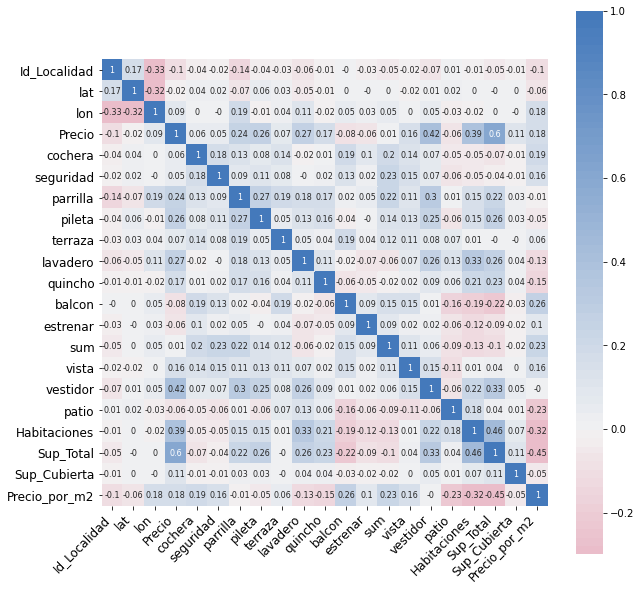

In [9]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    data.corr().round(2),
    annot     = True,
    cbar      = True,
    annot_kws = {"size": 8},
    vmin      = -0.3,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(0, 250, n=100),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 12)

La correlación de Sup Total con Precio_por_m2 es elevada, pero
a su vez Sup_Total está incluida en el cálculo de dicha variable Target, por dicha razón es una
variable candidata a eliminar.

***A continuación exploraremos la variable Precio y Precio_por_m2 en diferentes gráficos para 
observar en qué escala realizar el trabajo (Normal o Logarítmica).***

**- Precios en Escala Normal.**

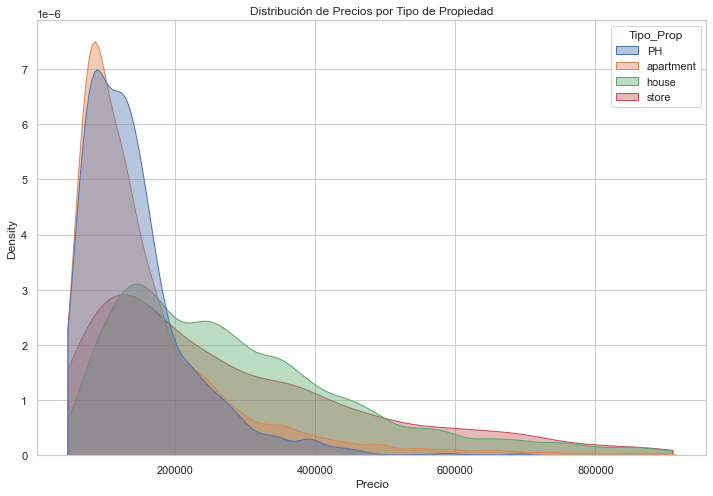

In [10]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Set transparency
sns.kdeplot(data=data, x="Precio", hue="Tipo_Prop", cut=0, fill=True, common_norm=False, alpha=0.4, log_scale=False).\
set_title("Distribución de Precios por Tipo de Propiedad")
plt.show()

Debido a que las variables económicas referidas a precios e ingresos tienen una distribución asimétrica (existen muchos inmuebles de poco valor y pocos de alto valor), realizamos transformaciónes logarítmicas sobre dichas variables.

El efecto que tendrá es que tomará la forma de una normal típica, lo que nos permite aprovechar todas las propiedades de dicha distribución.

In [11]:
# funcion para crear logs
def logs(serie, nombre):
    """La funcion requiere de una serie de pandas y un string con el nombre de la nueva columna a generar
        Devuelve una columna nueva con el logaritmo de la original
    """
    data[nombre] = serie.apply(np.log)
    return


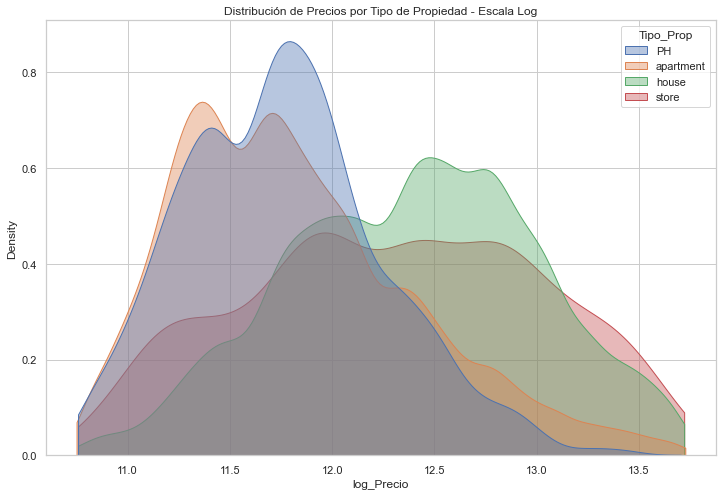

In [12]:
logs(data.Precio, 'log_Precio')
plt.rcParams["figure.figsize"]=12,8
sns.kdeplot(data=data, x="log_Precio", hue="Tipo_Prop", cut=0, fill=True, common_norm=False, alpha=0.4, log_scale=False).\
set_title("Distribución de Precios por Tipo de Propiedad - Escala Log")
plt.show()

Veremos ahora el Precio_por_m2 en escala normal.

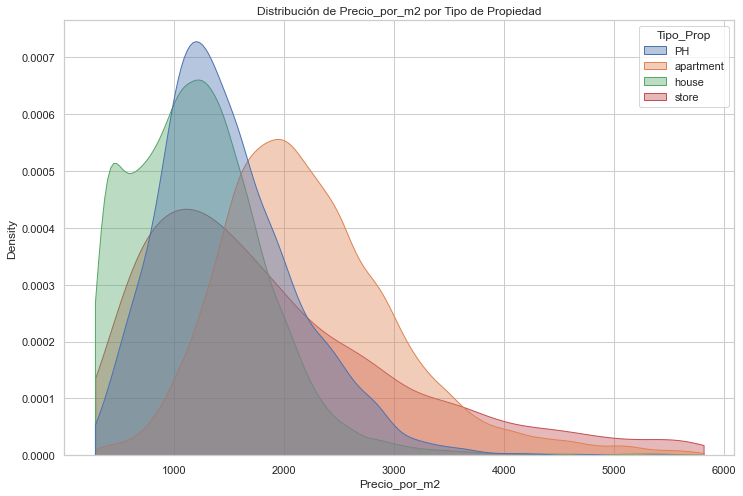

In [13]:
plt.rcParams["figure.figsize"]=12,8
sns.kdeplot(data=data, x="Precio_por_m2", hue="Tipo_Prop", cut=0, fill=True, common_norm=False, alpha=0.4, log_scale=False).\
set_title("Distribución de Precio_por_m2 por Tipo de Propiedad")
plt.show()

Ahora Precio_por_m2 en escala logarítmica.

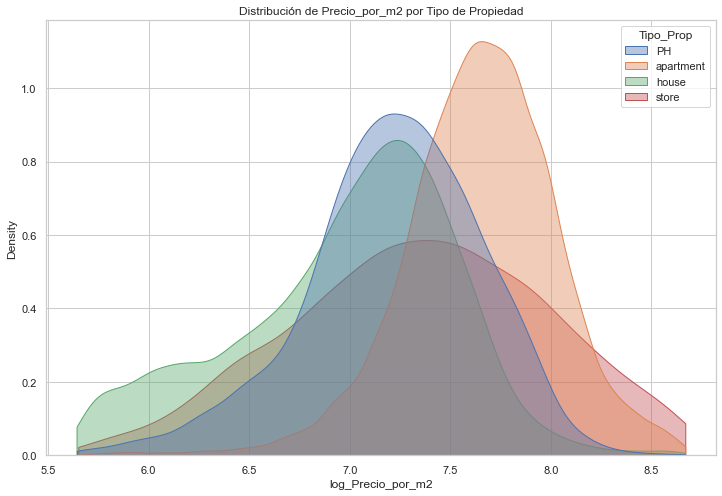

In [14]:
logs(data.Precio_por_m2, 'log_Precio_por_m2')
sns.kdeplot(data=data, x="log_Precio_por_m2", hue="Tipo_Prop", cut=0, fill=True, common_norm=False, alpha=0.4, log_scale=False).\
set_title("Distribución de Precio_por_m2 por Tipo de Propiedad")
plt.show()

**Otra manera de verlo: Con un gráfico de PairPlot**

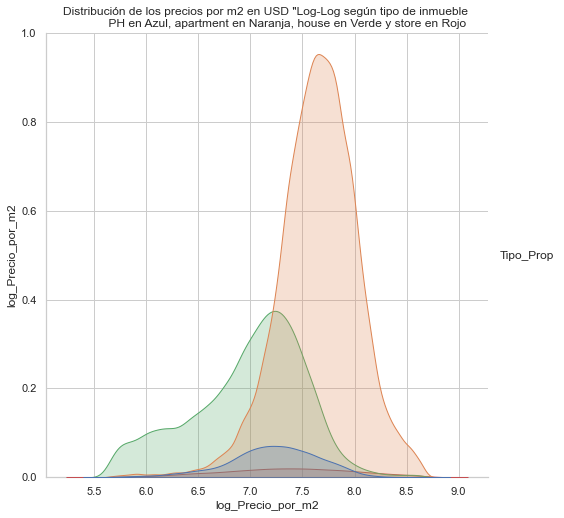

In [15]:
logs(data.Precio_por_m2, 'log_Precio_por_m2')
plt.rcParams["figure.figsize"]=12,8
sns.pairplot(data, vars=['log_Precio_por_m2'], hue='Tipo_Prop', height=7, markers='Tipo_Prop');
plt.title('Distribución de los precios por m2 en USD "Log-Log según tipo de inmueble \n \
           PH en Azul, apartment en Naranja, house en Verde y store en Rojo');

**Como las distribuciones del Precio_por_m2 no se encuentran muy alejadas unas de otras,
para simplificar el análisis trabajaremos dicha variable en escala normal, pero iniciaremos el mismo trabajando en escala logarítmica**

<a id="section_modelo_base"></a> 
### 5. MODELO BASE DE REGRESIÓN LINEAL


Para poder interpretar las relaciones entre la variable objetivo (Target) y las descriptivas (Features), partimos de un modelo relativamente sencillo, y lo ejecutamos con StatsModels para verificar la significancia de las variables. 


<p style="font-size:25px;">    
$$Y = \beta_0 + \beta_1. TipoProp + \beta_2. Localidad + \beta_3. Hab + 
\beta_4. SupCub + \beta_5. SupTotal $$ 
</p>


### **Interpretación de resultados**
El modelo de Precios Hedónicos tiene la particularidad de ser fácilmente interpretable. Debido a que nuestro modelo tiene como objetivo una variable que sufrió una transformación logarítmica, la interpretación es ligeramente distinta.

Empíricamente, se ha descartado la hipótesis de relación lineal, encontrándose valores del vector de coeficientes  cercanos a cero, lo que lleva a la conclusión de que la forma funcional "f"  en la ecuación anterior tiende a ser muy aproximada a la logarítmica.

Finalmente, para poder obtener los precios en dólares y poder compararlos con la realidad, es necesario transformar el modelo nuevamente para eliminar el logaritmo. Esto es simplemente:

### ln(Precio_por_m2) = $\beta_0 + \beta_i xi$
### e^(ln(Precio_por_m2)) = e^($\beta_0 + \beta_i xi$)
O lo que es lo mismo:
### Precio_por_m2 = e^($\beta_0 + \beta_i xi$)

**1 - Con variables numéricas Habitaciones, Superficie Total y Sup_Cubierta**

***Definamos una funcion: obtener_X_y_train la cual utilizaremos más adelante.***

In [16]:
def obtener_X_y_train(data, num_features, cat_features, target_feature, test_size=0.25, random_state=120):
    """La funcion requiere de un DF de pandas, una lista de features numericos, una lista de features categoricos,
    un string de la variable target.
        Devuelve un DF y un Array con las Features y Target respectivamente.
    """
    Xn = data[num_features]
    Xc = data[cat_features]
    y = data[target_feature]
    X = pd.concat([Xn, Xc], axis=1).reset_index(drop=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=120)
    df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    return df_train

In [17]:
# 1 - SEPARAMOS LOS FEATURES
# Por el momento no utilizaremos Features Categ'oricas
num_features = ['Sup_Cubierta', 'Habitaciones', 'Sup_Total']
cat_features = ['Tipo_Prop', 'Localidad']
target_feature = 'log_Precio_por_m2'

In [18]:
# 2 - Definimos vectores de Features y Target
X = data[num_features]
y = data[target_feature]

In [19]:

# 3 - Realizamos Train_Test_Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 120)
data_train = pd.concat([X_train,y_train], axis=1).reset_index(drop=True)
data_train

Sup_Cubierta  Habitaciones  Sup_Total  log_Precio_por_m2
0              38.0           2.0       38.0           7.504276
1             100.0           5.0      100.0           6.551080
2             380.0           4.0      380.0           6.528266
3              91.0           2.0      117.0           7.587999
4              44.0           1.0       47.0           8.437505
...             ...           ...        ...                ...
58641          28.0           1.0       34.0           7.460832
58642          65.0           3.0       65.0           7.286192
58643          37.0           2.0       61.0           7.592159
58644         114.0           4.0      114.0           7.182192
58645         160.0           5.0      180.0           7.275480

[58646 rows x 4 columns]

In [20]:
# 4 - Evaluamos el modelo
model_1 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + Sup_Total + Habitaciones', data=data_train)
model_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                 1.040e+04
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:41:22   Log-Likelihood:                -34872.
No. Observations:               58646   AIC:                         6.975e+04
Df Residuals:                   58642   BIC:                         6.979e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.8155      0.004   1792.081      0.000       7.807       7.824
Sup_Cubierta  9.852e-06   2.34e-06      4.214      0.000    5.27e-06    1.44e-05
Sup_Total       -0.0018   1.32e-05   -138.807      0.000      -0.002      -0.002
Habitaciones    -0.0505      0.002    -32.873      0.000      -0.053      -0.047
==============================================================================
Omnibus:                     1132.595   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1306.849
Skew:                          -0.297   Prob(JB):                    1.66e-284
Kurtosis:                       3.427   Cond. No.                     1.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="section_agregando_var_cat"></a> 
### 6. AGREGANDO VARIABLES CATEGÓRICAS AL MODELO
Para poder incrementar el rendimiento del modelo, le agregaremos las variables categóricas mencionadas anteriormente:
 - Tipo de propiedad
 - Barrio

***6.1 - AGREGAMOS  VARIABLES CATEGÓRICAS (TIPO_PROP Y BARRIO) Y EN ESTE CASO TRATAREMOS EN ESTE CASO LA VARIABLE HABITACIONES COMO UNA VARIABLE NUMÉRICA.***

In [21]:
num_features = ['Sup_Cubierta', 'Habitaciones', 'Sup_Total']
cat_features = ['Tipo_Prop', 'Localidad']
target_feature = 'log_Precio_por_m2'

In [22]:
data_train_m2 = obtener_X_y_train(data, num_features, cat_features, 
                target_feature, test_size=0.25, random_state=120)

In [23]:
data_train_m2

Sup_Cubierta  Habitaciones  Sup_Total  Tipo_Prop        Localidad  \
0              38.0           2.0       38.0  apartment  Villa Luzuriaga   
1             100.0           5.0      100.0      house        La Granja   
2             380.0           4.0      380.0      house          Quilmes   
3              91.0           2.0      117.0  apartment  Capital Federal   
4              44.0           1.0       47.0  apartment         Belgrano   
...             ...           ...        ...        ...              ...   
58641          28.0           1.0       34.0  apartment          Rosario   
58642          65.0           3.0       65.0  apartment             Boca   
58643          37.0           2.0       61.0  apartment    Villa Urquiza   
58644         114.0           4.0      114.0      house     Luis Guillón   
58645         160.0           5.0      180.0      house          Pinamar   

       log_Precio_por_m2  
0               7.504276  
1               6.551080  
2               6.528266  
3               7.587999  
4               8.437505  
...                  ...  
58641           7.460832  
58642           7.286192  
58643           7.592159  
58644           7.182192  
58645           7.275480  

[58646 rows x 6 columns]

In [24]:
# Realizamos una transformación en las variables Categóricas a dummies.
model_2 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + Habitaciones  + Sup_Total + \
            C(Tipo_Prop) + C(Localidad)', data= data_train_m2)
model_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     143.3
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:41:41   Log-Likelihood:                -15920.
No. Observations:               58646   AIC:                         3.340e+04
Df Residuals:                   57868   BIC:                         4.038e+04
Df Model:                         777                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   7.5464      0.226     33.376      0.000       7.103       7.990
C(Tipo_Prop)[T.apartment]                                   0.2845      0.006     44.943      0.000       0.272       0.297
C(Tipo_Prop)[T.house]                                       0.0457      0.007      6.681      0.000       0.032       0.059
C(Tipo_Prop)[T.store]                                       0.2923      0.011     26.802      0.000       0.271       0.314
C(Localidad)[T. los alamos]                                -0.3830      0.391     -0.979      0.328      -1.150       0.384
C(Localidad)[T.9 de Abril]                                 -0.5908      0.391     -1.509      0.131      -1.358       0.177
C(Localidad)[T.Abasto]                                     -0.1241      0.230     -0.540      0.589      -0.574       0.326
C(Localidad)[T.Abril Club de Campo]                         0.2623      0.292      0.899      0.369      -0.309       0.834
C(Localidad)[T.Acacias Blancas]                            -0.2089      0.234     -0.893      0.372      -0.667       0.250
C(Localidad)[T.Acassuso]                                    0.2153      0.228      0.945      0.345      -0.231       0.662
C(Localidad)[T.Achiras]                                    -0.2272      0.391     -0.581      0.562      -0.994       0.540
C(Localidad)[T.Adrogué]                                    -0.0264      0.226     -0.117      0.907      -0.470       0.417
C(Localidad)[T.Aeropuerto Internacional Ezeiza]            -0.3640      0.391     -0.930      0.352      -1.131       0.403
C(Localidad)[T.Agronomía]                                  -0.0401      0.234     -0.172      0.864      -0.498       0.418
C(Localidad)[T.Agua de Oro]                                 0.6612      0.391      1.689      0.091      -0.106       1.428
C(Localidad)[T.Aguas Verdes]                               -0.9675      0.292     -3.316      0.001      -1.539      -0.396
C(Localidad)[T.Albanueva Barrio Cerrado]                    0.3286      0.256      1.282      0.200      -0.174       0.831
C(Localidad)[T.Aldo Bonzi]                                 -0.6863      0.391     -1.754      0.080      -1.453       0.081
C(Localidad)[T.Alejandro Korn]                             -0.5904      0.256     -2.304      0.021      -1.093      -0.088
C(Localidad)[T.Alem]                                       -0.6497      0.320     -2.033      0.042      -1.276      -0.023
C(Localidad)[T.Almafuerte]                                 -1.3782      0.391     -3.520      0.000      -2.145      -0.611
C(Localidad)[T.Almagro]                                    -0.0574      0.226     -0.253      0.800      -0

***Podemos ver que el modelo performa mejor tanto en el Set de Training como el Set de Testeo.***

***6.2 - AGREGAMOS  VARIABLES CATEGÓRICAS TIPO_PROP Y LOCALIDAD Y EN ESTE CASO TRATAREMOS EN ESTE CASO LA VARIABLE HABITACIONES COMO UNA VARIABLE CATEGÓRICA.***

Haremos una transformación en la variable Habitaciones pasandola como variable categórica
en el mismo modelo de StatsMoldels. Agregandole la letra C, lo que hace el modelo es generar las dummies correspondientes. Veamos como se comporta en el modelo que denominaremos model_3.

In [25]:
model_3 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + C(Habitaciones)  + Sup_Total + \
            C(Tipo_Prop) + C(Localidad)', data= data_train_m2)
model_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     139.9
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:42:02   Log-Likelihood:                -15805.
No. Observations:               58646   AIC:                         3.321e+04
Df Residuals:                   57845   BIC:                         4.040e+04
Df Model:                         800                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   7.5263      0.226     33.339      0.000       7.084       7.969
C(Habitaciones)[T.2.0]                                      0.0524      0.006      8.756      0.000       0.041       0.064
C(Habitaciones)[T.3.0]                                      0.0274      0.007      4.113      0.000       0.014       0.040
C(Habitaciones)[T.4.0]                                      0.0915      0.007     12.675      0.000       0.077       0.106
C(Habitaciones)[T.5.0]                                      0.0691      0.010      7.209      0.000       0.050       0.088
C(Habitaciones)[T.6.0]                                      0.0833      0.014      5.924      0.000       0.056       0.111
C(Habitaciones)[T.7.0]                                      0.1288      0.019      6.714      0.000       0.091       0.166
C(Habitaciones)[T.8.0]                                      0.1305      0.029      4.470      0.000       0.073       0.188
C(Habitaciones)[T.9.0]                                      0.0459      0.039      1.190      0.234      -0.030       0.121
C(Habitaciones)[T.10.0]                                     0.0323      0.036      0.887      0.375      -0.039       0.104
C(Habitaciones)[T.11.0]                                    -0.0390      0.058     -0.673      0.501      -0.153       0.075
C(Habitaciones)[T.12.0]                                     0.0570      0.069      0.829      0.407      -0.078       0.192
C(Habitaciones)[T.13.0]                                     0.0978      0.090      1.085      0.278      -0.079       0.275
C(Habitaciones)[T.14.0]                                    -0.0067      0.111     -0.061      0.952      -0.224       0.211
C(Habitaciones)[T.15.0]                                     0.2475      0.117      2.114      0.035       0.018       0.477
C(Habitaciones)[T.16.0]                                     0.2644      0.327      0.808      0.419      -0.377       0.906
C(Habitaciones)[T.17.0]                                    -0.0083      0.185     -0.045      0.964      -0.370       0.354
C(Habitaciones)[T.18.0]                                     0.4802      0.321      1.494      0.135      -0.150       1.110
C(Habitaciones)[T.19.0]                                    -0.3057      0.466     -0.656      0.512      -1.219       0.608
C(Habitaciones)[T.20.0]                                     0.4208      0.172      2.448      0.014       0.084       0.758
C(Habitaciones)[T.21.0]                                     0.5722      0.232      2.470      0.014       0.118       1.026
C(Habitaciones)[T.22.0]                                    -0.0349      0.227     -0.153      0.878      -0

***Como conclusión de tratar la variable Habitaciones como una variable Categórica Ordinal, vemos que el rendimiento del modelo mejora levemente por lo cual lo cual trataremos a dicha variable de ahora en adelante como variable categórica.***

***6.3 - AGREGAMOS MÁS VARIABLES CATEGÓRICAS AL MODELO***

In [26]:
num_features = ['Sup_Cubierta', 'Habitaciones', 'Sup_Total']
cat_features = ['Tipo_Prop', 'Localidad', 'cochera', 'seguridad', 'parrilla', 'pileta', 
                'terraza', 'lavadero','quincho', 'balcon', 'estrenar', 'sum', 
                'vista', 'vestidor', 'patio']
target_feature = 'log_Precio_por_m2'

Cabe aclarar que ahora a la variable Habitaciones siempre le haremos la transformación de numérica a categórica uando instanciemos el modelo de Statsmodels.

In [27]:
data_train_m4 = obtener_X_y_train(data, num_features, cat_features,
                target_feature, test_size=0.25, random_state=120)

In [28]:
model_4 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + C(Habitaciones) + Sup_Total + \
            C(Tipo_Prop) + C(Localidad) + cochera + seguridad + parrilla + \
            pileta + terraza + lavadero + quincho + balcon + estrenar + \
            sum + vista + vestidor + patio', data= data_train_m4)
model_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     156.1
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:42:22   Log-Likelihood:                -13318.
No. Observations:               58646   AIC:                         2.826e+04
Df Residuals:                   57832   BIC:                         3.557e+04
Df Model:                         813                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   7.3661      0.216     34.029      0.000       6.942       7.790
C(Habitaciones)[T.2.0]                                      0.0618      0.006     10.703      0.000       0.050       0.073
C(Habitaciones)[T.3.0]                                      0.0362      0.006      5.590      0.000       0.024       0.049
C(Habitaciones)[T.4.0]                                      0.0892      0.007     12.630      0.000       0.075       0.103
C(Habitaciones)[T.5.0]                                      0.0674      0.009      7.238      0.000       0.049       0.086
C(Habitaciones)[T.6.0]                                      0.0787      0.014      5.798      0.000       0.052       0.105
C(Habitaciones)[T.7.0]                                      0.1274      0.018      6.902      0.000       0.091       0.164
C(Habitaciones)[T.8.0]                                      0.1405      0.028      5.007      0.000       0.085       0.195
C(Habitaciones)[T.9.0]                                      0.0581      0.037      1.571      0.116      -0.014       0.131
C(Habitaciones)[T.10.0]                                     0.0599      0.035      1.710      0.087      -0.009       0.129
C(Habitaciones)[T.11.0]                                    -0.0178      0.056     -0.319      0.749      -0.127       0.091
C(Habitaciones)[T.12.0]                                     0.0755      0.066      1.146      0.252      -0.054       0.205
C(Habitaciones)[T.13.0]                                     0.0474      0.086      0.548      0.583      -0.122       0.217
C(Habitaciones)[T.14.0]                                     0.0054      0.107      0.051      0.960      -0.203       0.214
C(Habitaciones)[T.15.0]                                     0.2608      0.112      2.323      0.020       0.041       0.481
C(Habitaciones)[T.16.0]                                     0.0396      0.314      0.126      0.900      -0.576       0.655
C(Habitaciones)[T.17.0]                                    -0.0855      0.177     -0.483      0.629      -0.432       0.261
C(Habitaciones)[T.18.0]                                     0.4502      0.308      1.461      0.144      -0.154       1.054
C(Habitaciones)[T.19.0]                                    -0.2266      0.447     -0.507      0.612      -1.102       0.649
C(Habitaciones)[T.20.0]                                     0.5220      0.165      3.167      0.002       0.199       0.845
C(Habitaciones)[T.21.0]                                     0.3917      0.222      1.764      0.078      -0.044       0.827
C(Habitaciones)[T.22.0]                                    -0.1481      0.218     -0.680      0.497      -0

***De este último análisis se pueden extraer varios puntos importantes a mencionar:***

* *Podemos ver que el rendimiento del modelo mejoró pero se observan problemas de fuerte multicolinealidad.*

*  **Prob (F-statistic):               0.00 Me dice que el modelo es significativo.**

**AIC:	2.826e+04**

**BIC:	3.557e+04**

**El Criterio de información bayesiano (BIC) y Criterio de Información de Akaike (AIC) disminuyeron respecto de los otros modelos, lo cual es un dato positivo en la selección del mismo, sin embargo siguen siendo valores elevados.**

<a id="section_limpieza_y_transformacion"></a> 
### 7. TRABAJOS DE LIMPIEZA Y TRANSFORMACIÓN SOBRE LOS DATOS

Como resultado del último análisis podemos ver que existen muchas variables no significativas para el modelo. 
Entre ellas podemos mencionar:
 - Lavadero
 - Varias Localidades

Trataremos de realizar un filtrado de las mismas para mejorar el rendimiento del modelo.

### 7.1 Limpieza de Datos que NO Aporten al Modelo

Definimos una función para observar las varianzas y estadísticos básicos y ordenamos las localidades por 
la desviación estándar.

In [29]:
def observar_varianzas(df):
    varianzas = df.groupby('Localidad')['log_Precio_por_m2'].describe()
    print("Varianza de log_Precio_por_m2")
    print("Shape de Datos: ", varianzas.shape[0])
    display (varianzas)
    var_modelo_sin_nan = varianzas.loc[varianzas['std'].isnull()==False].sort_values('std', ascending=False)
    print("Varianza de log_Precio_por_m2 ordenada y sin valores NaN")
    print("Shape de Datos: ", var_modelo_sin_nan.shape[0])
    display (var_modelo_sin_nan)

In [30]:
observar_varianzas(data)

Varianza de log_Precio_por_m2
Shape de Datos:  834


count      mean       std       min       25%  \
Localidad                                                                
 Country Maschwitz Club    3.0  7.031656  0.364860  6.700116  6.836205   
 los alamos                1.0  7.377759       NaN  7.377759  7.377759   
9 de Abril                 1.0  6.620073       NaN  6.620073  6.620073   
Abasto                    94.0  7.541918  0.331542  6.660895  7.316279   
Abril Club de Campo        5.0  7.160042  0.483012  6.357709  7.257131   
...                        ...       ...       ...       ...       ...   
Wilde                    113.0  7.249504  0.420988  5.666969  7.079606   
William Morris             1.0  7.119064       NaN  7.119064  7.119064   
Yerba Buena               19.0  6.782045  0.460748  5.843922  6.578154   
Zelaya                     3.0  7.044050  0.112292  6.972294  6.979346   
Zárate                     2.0  6.800162  0.337897  6.561233  6.680697   

                              50%       75%       max  
Localidad                                              
 Country Maschwitz Club  6.972294  7.197425  7.422557  
 los alamos              7.377759  7.377759  7.377759  
9 de Abril               6.620073  6.620073  6.620073  
Abasto                   7.589505  7.821664  8.069881  
Abril Club de Campo      7.257131  7.257131  7.671107  
...                           ...       ...       ...  
Wilde                    7.352441  7.511290  8.077827  
William Morris           7.119064  7.119064  7.119064  
Yerba Buena              6.942534  7.116759  7.430420  
Zelaya                   6.986398  7.079928  7.173458  
Zárate                   6.800162  6.919627  7.039091  

[834 rows x 8 columns]

Varianza de log_Precio_por_m2 ordenada y sin valores NaN
Shape de Datos:  635


count      mean       std       min  \
Localidad                                                                      
Barrio Parque San Martin                   3.0  6.368348  1.235568  5.654992   
Barrio Cerrado "Sausalito"                 2.0  6.617628  1.206637  5.764407   
Barrio Santa Guadalupe - Pilar del Este    7.0  6.632049  1.197816  5.672607   
Las Grutas                                 2.0  6.942423  1.126856  6.145615   
Barrio Cerrado Fincas de Maschwitz         3.0  6.847460  0.949456  5.813916   
...                                        ...       ...       ...       ...   
Chivilcoy                                  3.0  8.091706  0.013679  8.080595   
Formosa                                    4.0  7.318386  0.007674  7.306894   
Barrio Cerrado "Roble Joven"               2.0  6.730739  0.000000  6.730739   
Dunamar                                    2.0  6.378911  0.000000  6.378911   
Country Farm Club                          2.0  7.555440  0.000000  7.555440   

                                              25%       50%       75%  \
Localidad                                                               
Barrio Parque San Martin                 5.654992  5.654992  6.725025   
Barrio Cerrado "Sausalito"               6.191018  6.617628  7.044239   
Barrio Santa Guadalupe - Pilar del Este  5.687653  5.790794  7.534221   
Las Grutas                               6.544019  6.942423  7.340826   
Barrio Cerrado Fincas de Maschwitz       6.430717  7.047517  7.364231   
...                                           ...       ...       ...   
Chivilcoy                                8.084067  8.087538  8.097261   
Formosa                                  7.317945  7.321985  7.322426   
Barrio Cerrado "Roble Joven"             6.730739  6.730739  6.730739   
Dunamar                                  6.378911  6.378911  6.378911   
Country Farm Club                        7.555440  7.555440  7.555440   

                                              max  
Localidad                                          
Barrio Parque San Martin                 7.795058  
Barrio Cerrado "Sausalito"               7.470849  
Barrio Santa Guadalupe - Pilar del Este  8.517193  
Las Grutas                               7.739230  
Barrio Cerrado Fincas de Maschwitz       7.680945  
...                                           ...  
Chivilcoy                                8.106984  
Formosa                                  7.322682  
Barrio Cerrado "Roble Joven"             6.730739  
Dunamar                                  6.378911  
Country Farm Club                        7.555440  

[635 rows x 8 columns]

Podemos ver que sólo 635 de las localidades, de un total de 834, tienen valores de log_Precio_por_m2, es decir 
están aportando al sistema. Trataremos de eliminar las localidades que menor aporte realizan al modelo,
filtrando datos por provincia.

In [31]:
#VEMOS QUE LOS PRIMEROS 7 REPRESENTAN EL 95% DE LOS DATOS.
mascara = data.Provincia.value_counts().head(7)
print(mascara)
print(mascara.sum())
print(mascara.sum()/data.shape[0]*100)
data["Prov1"] = data.Provincia.apply(lambda x: x if x in mascara else "Otros")
print(data["Prov1"].unique())
dfx = data.Prov1.value_counts().reset_index()
dfx.columns = ['Provincia', 'Cantidad']
dfx["% total"] = round(dfx["Cantidad"]/dfx["Cantidad"].sum()*100,2)
dfx = dfx.set_index('Provincia')
dfx

Capital Federal                 23930
Bs.As. G.B.A. Zona Norte        19929
Bs.As. G.B.A. Zona Sur           9228
Buenos Aires Costa Atlántica     6646
Córdoba                          5638
Bs.As. G.B.A. Zona Oeste         5530
Santa Fe                         4087
Name: Provincia, dtype: int64
74988
95.89871475158259
['Capital Federal' 'Buenos Aires Costa Atlántica'
 'Bs.As. G.B.A. Zona Norte' 'Bs.As. G.B.A. Zona Oeste' 'Córdoba'
 'Bs.As. G.B.A. Zona Sur' 'Otros' 'Santa Fe']


Cantidad  % total
Provincia                                      
Capital Federal                  23930    30.60
Bs.As. G.B.A. Zona Norte         19929    25.49
Bs.As. G.B.A. Zona Sur            9228    11.80
Buenos Aires Costa Atlántica      6646     8.50
Córdoba                           5638     7.21
Bs.As. G.B.A. Zona Oeste          5530     7.07
Santa Fe                          4087     5.23
Otros                             3207     4.10

[Text(0, 0, 'Capital Federal'),
 Text(1, 0, 'Bs.As. G.B.A. Zona Norte'),
 Text(2, 0, 'Bs.As. G.B.A. Zona Sur'),
 Text(3, 0, 'Buenos Aires Costa Atlántica'),
 Text(4, 0, 'Córdoba'),
 Text(5, 0, 'Bs.As. G.B.A. Zona Oeste'),
 Text(6, 0, 'Santa Fe'),
 Text(7, 0, 'Otros')]

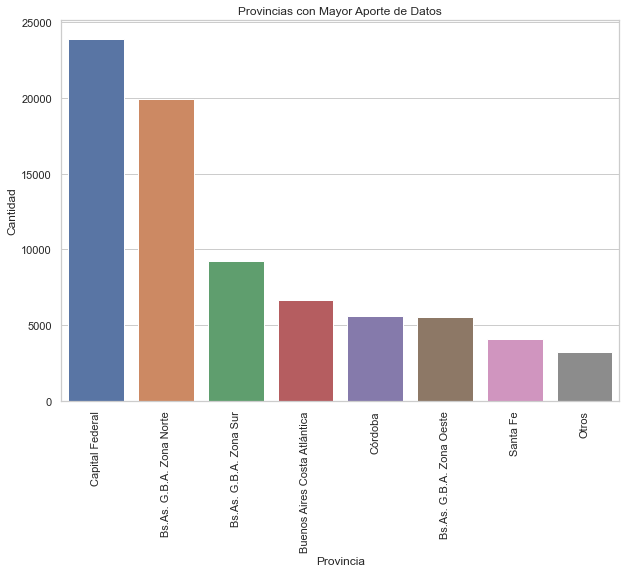

In [32]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 7)) 
g = sns.barplot(dfx.index, dfx.Cantidad)
g.set(title='Provincias con Mayor Aporte de Datos')
g.set_xticklabels(labels=dfx.index, rotation=90)

Podemos ver que hay provincias que poco aportan al modelo, por lo tanto borraremos las provincias categorizadas como
"Otros" y generaremos un nuevo dataset.

In [33]:
data_clean = data.loc[(data.Provincia==dfx.index[0])|(data.Provincia==dfx.index[1])|\
                   (data.Provincia==dfx.index[2])|(data.Provincia==dfx.index[3])|\
                   (data.Provincia==dfx.index[4])|(data.Provincia==dfx.index[5])|\
                   (data.Provincia==dfx.index[6])] 

Verificamos la dimensión del mismo, de manera de corroborar no haber perdido una gran cantidad de datos y borramos las variables "lavadero" (Que ya habíamos visto que no es significativa almodelo) y "Prov1" (Variable Auxiliar).

Chequeamos luego con la función obtener_info_data.

In [34]:
data_clean.shape

(74988, 27)

In [35]:
data_clean.drop('lavadero', axis=1, inplace=True)
data_clean.drop('Prov1', axis=1, inplace=True)

In [36]:
obtener_info_data(data_clean)

Nulos NoNulos  NulosPorc  NoNulosPorc TypeData
Tipo_Prop             0   74988        0.0        100.0   object
Localidad             0   74988        0.0        100.0   object
Provincia             0   74988        0.0        100.0   object
Id_Localidad       9976   65012       13.3         86.7  float64
lat                4562   70426        6.1         93.9  float64
lon                4562   70426        6.1         93.9  float64
Precio                0   74988        0.0        100.0  float64
cochera               0   74988        0.0        100.0    int64
seguridad             0   74988        0.0        100.0    int64
parrilla              0   74988        0.0        100.0    int64
pileta                0   74988        0.0        100.0    int64
terraza               0   74988        0.0        100.0    int64
quincho               0   74988        0.0        100.0    int64
balcon                0   74988        0.0        100.0    int64
estrenar              0   74988        0.0        100.0    int64
sum                   0   74988        0.0        100.0    int64
vista                 0   74988        0.0        100.0    int64
vestidor              0   74988        0.0        100.0    int64
patio                 0   74988        0.0        100.0    int64
Habitaciones          0   74988        0.0        100.0  float64
Sup_Total             0   74988        0.0        100.0  float64
Sup_Cubierta          0   74988        0.0        100.0  float64
Precio_por_m2         0   74988        0.0        100.0  float64
log_Precio            0   74988        0.0        100.0  float64
log_Precio_por_m2     0   74988        0.0        100.0  float64

Chequeamos como quedaron los datos de varianzas para el nuevo dataset.

In [37]:
observar_varianzas(data_clean)

Varianza de log_Precio_por_m2
Shape de Datos:  673


count      mean       std       min       25%  \
Localidad                                                                
 Country Maschwitz Club    3.0  7.031656  0.364860  6.700116  6.836205   
 los alamos                1.0  7.377759       NaN  7.377759  7.377759   
9 de Abril                 1.0  6.620073       NaN  6.620073  6.620073   
Abasto                    94.0  7.541918  0.331542  6.660895  7.316279   
Abril Club de Campo        5.0  7.160042  0.483012  6.357709  7.257131   
...                        ...       ...       ...       ...       ...   
Virrey del Pino            5.0  6.761145  0.311410  6.204558  6.877902   
Virreyes                  29.0  7.012808  0.434992  5.809143  6.731005   
Wilde                    113.0  7.249504  0.420988  5.666969  7.079606   
William Morris             1.0  7.119064       NaN  7.119064  7.119064   
Zelaya                     3.0  7.044050  0.112292  6.972294  6.979346   

                              50%       75%       max  
Localidad                                              
 Country Maschwitz Club  6.972294  7.197425  7.422557  
 los alamos              7.377759  7.377759  7.377759  
9 de Abril               6.620073  6.620073  6.620073  
Abasto                   7.589505  7.821664  8.069881  
Abril Club de Campo      7.257131  7.257131  7.671107  
...                           ...       ...       ...  
Virrey del Pino          6.907755  6.907755  6.907755  
Virreyes                 7.115395  7.288528  7.943309  
Wilde                    7.352441  7.511290  8.077827  
William Morris           7.119064  7.119064  7.119064  
Zelaya                   6.986398  7.079928  7.173458  

[673 rows x 8 columns]

Varianza de log_Precio_por_m2 ordenada y sin valores NaN
Shape de Datos:  537


count      mean       std       min  \
Localidad                                                                      
Barrio Parque San Martin                   3.0  6.368348  1.235568  5.654992   
Barrio Cerrado "Sausalito"                 2.0  6.617628  1.206637  5.764407   
Barrio Santa Guadalupe - Pilar del Este    7.0  6.632049  1.197816  5.672607   
Barrio Cerrado Fincas de Maschwitz         3.0  6.847460  0.949456  5.813916   
El Pato                                    2.0  6.589750  0.948381  5.919144   
...                                        ...       ...       ...       ...   
Galapagos Country Club                     3.0  7.144984  0.032538  7.121862   
Altos de Matheu                            2.0  6.813384  0.015541  6.802395   
Barrio Cerrado "Roble Joven"               2.0  6.730739  0.000000  6.730739   
Country Farm Club                          2.0  7.555440  0.000000  7.555440   
Dunamar                                    2.0  6.378911  0.000000  6.378911   

                                              25%       50%       75%  \
Localidad                                                               
Barrio Parque San Martin                 5.654992  5.654992  6.725025   
Barrio Cerrado "Sausalito"               6.191018  6.617628  7.044239   
Barrio Santa Guadalupe - Pilar del Este  5.687653  5.790794  7.534221   
Barrio Cerrado Fincas de Maschwitz       6.430717  7.047517  7.364231   
El Pato                                  6.254447  6.589750  6.925054   
...                                           ...       ...       ...   
Galapagos Country Club                   7.126380  7.130899  7.156545   
Altos de Matheu                          6.807889  6.813384  6.818879   
Barrio Cerrado "Roble Joven"             6.730739  6.730739  6.730739   
Country Farm Club                        7.555440  7.555440  7.555440   
Dunamar                                  6.378911  6.378911  6.378911   

                                              max  
Localidad                                          
Barrio Parque San Martin                 7.795058  
Barrio Cerrado "Sausalito"               7.470849  
Barrio Santa Guadalupe - Pilar del Este  8.517193  
Barrio Cerrado Fincas de Maschwitz       7.680945  
El Pato                                  7.260357  
...                                           ...  
Galapagos Country Club                   7.182192  
Altos de Matheu                          6.824374  
Barrio Cerrado "Roble Joven"             6.730739  
Country Farm Club                        7.555440  
Dunamar                                  6.378911  

[537 rows x 8 columns]

In [38]:
df = data_clean.copy()
df = df.reset_index(drop=True)

In [39]:
num_features = ['Sup_Total', 'Sup_Cubierta']
cat_features = ['Tipo_Prop', 'Localidad', 'Habitaciones','cochera', 'seguridad', 'parrilla', 'pileta', 
                'terraza','quincho', 'balcon', 'estrenar', 'sum', 'vista', 'vestidor', 'patio']
target_feature = 'log_Precio_por_m2'

In [40]:
data_train_m5 = obtener_X_y_train(df, num_features, cat_features, 
                target_feature, test_size=0.25, random_state=120)

In [41]:
model_5 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + C(Habitaciones) + Sup_Total + \
            C(Tipo_Prop) + C(Localidad) + cochera + seguridad + parrilla + \
            pileta + terraza + quincho + balcon + estrenar + \
            sum + vista + vestidor + patio', data= data_train_m5)
model_5.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     183.9
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:42:46   Log-Likelihood:                -12615.
No. Observations:               56241   AIC:                         2.655e+04
Df Residuals:                   55582   BIC:                         3.244e+04
Df Model:                         658                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   7.2786      0.216     33.757      0.000       6.856       7.701
C(Habitaciones)[T.2.0]                                      0.0586      0.006     10.094      0.000       0.047       0.070
C(Habitaciones)[T.3.0]                                      0.0340      0.006      5.247      0.000       0.021       0.047
C(Habitaciones)[T.4.0]                                      0.0821      0.007     11.620      0.000       0.068       0.096
C(Habitaciones)[T.5.0]                                      0.0676      0.009      7.195      0.000       0.049       0.086
C(Habitaciones)[T.6.0]                                      0.0775      0.014      5.552      0.000       0.050       0.105
C(Habitaciones)[T.7.0]                                      0.1115      0.019      5.780      0.000       0.074       0.149
C(Habitaciones)[T.8.0]                                      0.1496      0.028      5.288      0.000       0.094       0.205
C(Habitaciones)[T.9.0]                                      0.0180      0.037      0.482      0.630      -0.055       0.091
C(Habitaciones)[T.10.0]                                     0.0294      0.041      0.715      0.475      -0.051       0.110
C(Habitaciones)[T.11.0]                                    -0.0160      0.055     -0.292      0.770      -0.123       0.091
C(Habitaciones)[T.12.0]                                     0.0394      0.075      0.524      0.600      -0.108       0.187
C(Habitaciones)[T.13.0]                                     0.2805      0.098      2.868      0.004       0.089       0.472
C(Habitaciones)[T.14.0]                                    -0.0124      0.113     -0.110      0.912      -0.233       0.208
C(Habitaciones)[T.15.0]                                     0.1839      0.133      1.384      0.166      -0.076       0.444
C(Habitaciones)[T.17.0]                                    -0.0215      0.176     -0.122      0.903      -0.367       0.324
C(Habitaciones)[T.18.0]                                     0.2462      0.216      1.138      0.255      -0.178       0.670
C(Habitaciones)[T.19.0]                                     0.3396      0.341      0.997      0.319      -0.328       1.007
C(Habitaciones)[T.20.0]                                     0.3553      0.154      2.314      0.021       0.054       0.656
C(Habitaciones)[T.21.0]                                     0.3613      0.224      1.614      0.106      -0.077       0.800
C(Habitaciones)[T.22.0]                                    -0.2068      0.177     -1.169      0.242      -0.553       0.140
C(Habitaciones)[T.25.0]                                     0.3783      0.216      1.750      0.080      -0

Podemos ver que prácticamente no se pierde información al haber eliminado esas provincias:
    
    R2 pasó de 0.687 a 0.685
    
    R2 Adj pasó de 0.683 a 0.682
    
    AIC mejoró, disminuyendo de 2.826e+04 a 2.65e+04
    
    BIC mejoró, disminuyendo de 3.5576e+04 a 3.244e+04

**Tal cual lo habíamos mencionado anteriormente, eliminaremos la Superficie Total del Modelo y  verificamos
su rendimiento.**

In [42]:
model_6 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + C(Habitaciones) + \
            C(Tipo_Prop) + C(Localidad) + cochera + seguridad + parrilla + \
            pileta + terraza + quincho + balcon + estrenar + \
            sum + vista + vestidor + patio', data= data_train_m5)
model_6.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     108.4
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:43:00   Log-Likelihood:                -21935.
No. Observations:               56241   AIC:                         4.519e+04
Df Residuals:                   55583   BIC:                         5.107e+04
Df Model:                         657                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   7.2230      0.254     28.383      0.000       6.724       7.722
C(Habitaciones)[T.2.0]                                      0.0400      0.007      5.844      0.000       0.027       0.053
C(Habitaciones)[T.3.0]                                     -0.0181      0.008     -2.374      0.018      -0.033      -0.003
C(Habitaciones)[T.4.0]                                     -0.0304      0.008     -3.661      0.000      -0.047      -0.014
C(Habitaciones)[T.5.0]                                     -0.1231      0.011    -11.216      0.000      -0.145      -0.102
C(Habitaciones)[T.6.0]                                     -0.1404      0.016     -8.568      0.000      -0.172      -0.108
C(Habitaciones)[T.7.0]                                     -0.1494      0.023     -6.593      0.000      -0.194      -0.105
C(Habitaciones)[T.8.0]                                     -0.0854      0.033     -2.561      0.010      -0.151      -0.020
C(Habitaciones)[T.9.0]                                     -0.1446      0.044     -3.282      0.001      -0.231      -0.058
C(Habitaciones)[T.10.0]                                    -0.2353      0.048     -4.857      0.000      -0.330      -0.140
C(Habitaciones)[T.11.0]                                    -0.2290      0.064     -3.552      0.000      -0.355      -0.103
C(Habitaciones)[T.12.0]                                    -0.2462      0.089     -2.775      0.006      -0.420      -0.072
C(Habitaciones)[T.13.0]                                     0.2073      0.115      1.796      0.073      -0.019       0.434
C(Habitaciones)[T.14.0]                                    -0.1962      0.133     -1.477      0.140      -0.457       0.064
C(Habitaciones)[T.15.0]                                    -0.0097      0.157     -0.062      0.951      -0.317       0.298
C(Habitaciones)[T.17.0]                                    -0.1215      0.208     -0.584      0.559      -0.529       0.286
C(Habitaciones)[T.18.0]                                     0.1836      0.255      0.719      0.472      -0.317       0.684
C(Habitaciones)[T.19.0]                                     0.2278      0.402      0.567      0.571      -0.560       1.016
C(Habitaciones)[T.20.0]                                     0.1278      0.181      0.705      0.481      -0.227       0.483
C(Habitaciones)[T.21.0]                                     0.0636      0.264      0.241      0.810      -0.454       0.581
C(Habitaciones)[T.22.0]                                    -0.3533      0.209     -1.693      0.090      -0.762       0.056
C(Habitaciones)[T.25.0]                                     0.2963      0.255      1.162      0.245      -0

**Podemos ver que el modelo baja significativamente de rendimiento: 

**R-squared:	0.562**

**R-squared Adj:	0.556**

**AIC:	4.519e+04**

**BIC:	5.107e+04**


### 7.2 Transformación de variables Amenities en una única variable "Comodidades".

Juntaremos todos los "Amenities" en una sola variable llamada "Comodidades", le haremos una transformación
en el modelo (C para obtener Dummies) y veremos como performa el mismo.

In [43]:
data_train_m7 = obtener_X_y_train(df, num_features, cat_features, 
                target_feature, test_size=0.25, random_state=120)

In [44]:
data_train_m7['Comodidades'] = data_train_m7.cochera + data_train_m7.seguridad + \
                                data_train_m7.parrilla + data_train_m7.pileta + data_train_m7.terraza + \
                                data_train_m7.quincho + data_train_m7.balcon + \
                                data_train_m7.estrenar + data_train_m7['sum'] + \
                                data_train_m7.vista + data_train_m7.vestidor + \
                                data_train_m7.patio


In [45]:
model_7 = smf.ols(formula='log_Precio_por_m2 ~ Sup_Cubierta + C(Habitaciones) + \
            C(Tipo_Prop) + C(Localidad) + C(Comodidades)', data= data_train_m7)
model_7.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_Precio_por_m2   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     105.1
Date:                Sun, 10 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:43:16   Log-Likelihood:                -22433.
No. Observations:               56241   AIC:                         4.618e+04
Df Residuals:                   55584   BIC:                         5.205e+04
Df Model:                         656                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                   7.1981      0.257     28.038      0.000       6.695       7.701
C(Habitaciones)[T.2.0]                                      0.0382      0.007      5.534      0.000       0.025       0.052
C(Habitaciones)[T.3.0]                                     -0.0226      0.008     -2.953      0.003      -0.038      -0.008
C(Habitaciones)[T.4.0]                                     -0.0333      0.008     -4.032      0.000      -0.050      -0.017
C(Habitaciones)[T.5.0]                                     -0.1319      0.011    -12.002      0.000      -0.153      -0.110
C(Habitaciones)[T.6.0]                                     -0.1532      0.016     -9.308      0.000      -0.185      -0.121
C(Habitaciones)[T.7.0]                                     -0.1652      0.023     -7.245      0.000      -0.210      -0.120
C(Habitaciones)[T.8.0]                                     -0.1070      0.034     -3.188      0.001      -0.173      -0.041
C(Habitaciones)[T.9.0]                                     -0.1571      0.044     -3.535      0.000      -0.244      -0.070
C(Habitaciones)[T.10.0]                                    -0.2658      0.049     -5.443      0.000      -0.362      -0.170
C(Habitaciones)[T.11.0]                                    -0.2517      0.065     -3.871      0.000      -0.379      -0.124
C(Habitaciones)[T.12.0]                                    -0.2680      0.089     -2.995      0.003      -0.443      -0.093
C(Habitaciones)[T.13.0]                                     0.2152      0.116      1.848      0.065      -0.013       0.443
C(Habitaciones)[T.14.0]                                    -0.2285      0.134     -1.705      0.088      -0.491       0.034
C(Habitaciones)[T.15.0]                                    -0.0354      0.158     -0.224      0.823      -0.345       0.275
C(Habitaciones)[T.17.0]                                    -0.1239      0.210     -0.590      0.555      -0.535       0.288
C(Habitaciones)[T.18.0]                                     0.1598      0.258      0.620      0.535      -0.345       0.665
C(Habitaciones)[T.19.0]                                     0.2631      0.406      0.649      0.517      -0.532       1.058
C(Habitaciones)[T.20.0]                                     0.0463      0.183      0.253      0.800      -0.312       0.405
C(Habitaciones)[T.21.0]                                     0.1402      0.266      0.526      0.599      -0.382       0.662
C(Habitaciones)[T.22.0]                                    -0.3462      0.211     -1.644      0.100      -0.759       0.066
C(Habitaciones)[T.25.0]                                     0.3042      0.257      1.182      0.237      -0

## Podemos ver que el modelo baja significativamente de rendimiento:

R-squared: 0.562   pasa a 0.554

R-squared: 0.556   pasa a 0.548

AIC: 4.519e+04     pasa a 4.618e+04

BIC: 5.107e+04     pasa a 5.205e+04

## La razón de la disminución de R2 y R2 Adj:
**Podría explicarse en que en el primer caso, se contaba con un total de 12 variables, de las cuales son **significativas al modelo sólo 10 variables.**
**En el segundo caso, si bien se contaba con un total de 11 variables, sólo **son significativas al modelo 9 de ellas. Por lo dicho, más allá que se simplicara un modelo, disminuyendo las variables totales, las que deben disminuir son las variables siginificativas al mismo, y en este caso no se cumple dicha condición**
**Debido a lo esplicado anteriormente, resumido en  una leve baja de rendimiento y a cuestiones de interpretabilidad, decidimos no trabajar con las variables agrupadas en "Comodidades".**

<a id="section_cross_validation"></a> 
### 8. HACIENDO CROSS VALIDATION DE LOS DIFERENTES MODELOS

Intentaremos realizar una análisis de Cross Validation en los diferentes modelos utilizados, a fin de evaluar en mayor profundidad su rendimiento en los datos de entrenamiento del modelo.

Recordemos el **modelo 3**, donde utilizamos Habitaciones como una variable categórica 
(Numérica inicialmente y transformada a categórica al momento de instanciar el modelo).
Ahora utilizaremos sklearn, por lo cual pasaremos dicha variable Habitaciones a su 
equivalente en variables dummies antes de instanciar el modelo. Veamos cómo plantear
la distribución de las variables con las que trabajaremos.

Modificaremos levemente la funcion creada más arriba para generar datos de train.

In [46]:
def get_df_train_df_test(data, num_features, cat_features, target_feature, 
                             test_size=0.25, random_state=120):
    
    """La funcion requiere de un DF de pandas, una lista de features numericos, una lista de features categoricos,
    un string de la variable target.
        Devuelve un DF y un Array con las Features y Target respectivamente.
    """
    Xn = data[num_features]
    Xc = data[cat_features]
    y = data[target_feature]
    Xc = pd.get_dummies(Xc, drop_first=True)
    if 'Habitaciones' in cat_features:
        hab_dumm = pd.get_dummies(data['Habitaciones'], drop_first=True)
        X = pd.concat([Xn, Xc, hab_dumm], axis=1).reset_index(drop=True)
        X.drop('Habitaciones', axis=1, inplace=True)
    else:
        X = pd.concat([Xn, Xc], axis=1).reset_index(drop=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=120)
    df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)    
    return df_train, df_test

### 8.1 Haremos Cross_Validation con el modelo de regresión lineal model_3:
En este modelo las features se distribuian de la siguiente manera:

In [47]:
num_features = ['Sup_Cubierta', 'Sup_Total']
cat_features = ['Tipo_Prop', 'Localidad', 'Habitaciones']
target_feature = 'log_Precio_por_m2'

Obtenemos Sets de Train y Test con la nueva función.

In [48]:
df_m3_train, df_m3_test = get_df_train_df_test(data, num_features, cat_features, target_feature, 
                             test_size=0.25, random_state=120)

In [49]:
lr = LinearRegression()

In [50]:
y = df_m3_train['log_Precio_por_m2']
X = df_m3_train.drop(['log_Precio_por_m2'], axis=1).copy()

In [51]:
model_3_cv = lr.fit(X,y)

In [52]:
cv_model_3 = cross_validate(model_3_cv, X, y, cv=5,
               scoring=('r2'),
               return_train_score=True) 

In [53]:
r2_score_model_3 =  cv_model_3['train_score'].mean()

In [54]:
row = {'Model':'Linear_Reg', 'Numerical_Features': num_features, 'Categ_Features': cat_features, 
       'Target': 'Log_Precio_por_m2','R2_Score': r2_score_model_3}

df_resultados_CV = pd.DataFrame(columns = ['Model', 'Numerical_Features', 'Categ_Features',
                                          'Target','R2_Score'])
df_resultados_CV = df_resultados_CV.append(row, ignore_index=True)
df_resultados_CV

Model         Numerical_Features  \
0  Linear_Reg  [Sup_Cubierta, Sup_Total]   

                         Categ_Features             Target  R2_Score  
0  [Tipo_Prop, Localidad, Habitaciones]  Log_Precio_por_m2  0.662979

### 8.2 Haremos Cross_Validation con el modelo de regresión lineal model_6:
En este modelo las features se distribuian de la siguiente manera:

In [55]:
df_1 = df.copy()

In [56]:
# ELIMINAMOS LA CANTIDAD DE HABITACIONES MAYOR A 12, YA QUE NO ERAN VARIABLES SIGNIFICATIVAS
df_1.drop(df_1.loc[df_1['Habitaciones'] > 12].index,inplace=True)
df_1 = df_1.reset_index(drop=True)

In [57]:
df = df_1.copy()

In [58]:
num_features = ['Sup_Cubierta']
cat_features = ['Tipo_Prop', 'Localidad', 'cochera', 'seguridad', 'parrilla', 'pileta', 
                'terraza','quincho', 'balcon', 'estrenar', 'sum', 'vista', 'vestidor', 'patio',
               'Habitaciones']
target_feature = 'log_Precio_por_m2'

In [59]:
df_m6_train, df_m6_test = get_df_train_df_test(df, num_features, cat_features, target_feature, 
                             test_size=0.25, random_state=120)

In [60]:
y = df_m6_train['log_Precio_por_m2']
X = df_m6_train.drop(['log_Precio_por_m2'], axis=1).copy()

In [61]:
model_6_cv = lr.fit(X,y)

In [62]:
cv_model_6 = cross_validate(model_6_cv, X, y, cv=5,
               scoring=('r2'),
               return_train_score=True) 

In [63]:
r2_score_model_6 =  cv_model_6['train_score'].mean()

In [64]:
row = {'Model':'Linear_Reg', 'Numerical_Features': num_features, 'Categ_Features': cat_features, 
       'Target': 'Log_Precio_por_m2','R2_Score': r2_score_model_6}
df_resultados_CV = df_resultados_CV.append(row, ignore_index=True)


In [65]:
df_resultados_CV.set_index('Model', inplace=True)

In [66]:
df_resultados_CV

Numerical_Features  \
Model                                   
Linear_Reg  [Sup_Cubierta, Sup_Total]   
Linear_Reg             [Sup_Cubierta]   

                                               Categ_Features  \
Model                                                           
Linear_Reg               [Tipo_Prop, Localidad, Habitaciones]   
Linear_Reg  [Tipo_Prop, Localidad, cochera, seguridad, par...   

                       Target  R2_Score  
Model                                    
Linear_Reg  Log_Precio_por_m2  0.662979  
Linear_Reg  Log_Precio_por_m2  0.564911

<a id="section_resumen_resultados"></a> 
### 9. REGRESION LINEAL PARA EL MODELO OBTENIDO - RESUMEN DE RESULTADOS (ARG)

### 9.1 Regresión Lineal 

Intentaremos realizar un resumen con todos los parámetros de una regresión lineal para el modelo final obtenido.
Recordemmos el mismo:

In [67]:
num_features = ['Sup_Cubierta']
cat_features = ['Tipo_Prop', 'Localidad', 'cochera', 'seguridad', 'parrilla', 'pileta', 
                'terraza','quincho', 'balcon', 'estrenar', 'sum', 'vista', 'vestidor', 'patio',
               'Habitaciones']
target_feature = 'log_Precio_por_m2'

In [68]:
df_model_train, df_model_test = get_df_train_df_test(df, num_features, cat_features, target_feature, 
                             test_size=0.25, random_state=120)

In [69]:
y_train = df_model_train['log_Precio_por_m2']
X_train = df_model_train.drop(['log_Precio_por_m2'], axis=1).copy()
y_test = df_model_test['log_Precio_por_m2']
X_test = df_model_test.drop(['log_Precio_por_m2'], axis=1).copy()

In [70]:
print('Se entrenarán a los modelos con ',len(X_train),'registros')
print('Se testearán a los modelos con ',len(X_test),'registros')

Se entrenarán a los modelos con  56189 registros
Se testearán a los modelos con  18730 registros


In [71]:
# Instancio el modelo
lin_model = LinearRegression()
# Fiteo el modelo
lin_model_fitted = lin_model.fit(X_train, y_train)

# Ejecuto una cross validation de 5 folds
scores_linear = cross_validate(lin_model_fitted, X_train, y_train, cv=5,
                       scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

# Predigo los valores 

y_predicted_linear_test = lin_model_fitted.predict(X_test)

# Calculo las Métricas

mse_score_linear_train = np.mean(scores_linear['test_neg_mean_squared_error']*-1)
r2_score_linear_train = np.mean(scores_linear['test_r2'])
r2_score_linear_test = lin_model_fitted.score(X_test, y_test)


# Dataframe donde muestro los resultados
df_resultados_Train = pd.DataFrame(columns=['Model', 'MSE', 'R^2', 'Alpha'])
df_resultados_Test = pd.DataFrame(columns=['Model', 'R^2'])

# Agrego los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'MSE': mse_score_linear_train, 'R^2': r2_score_linear_train, 
       'Alpha': 0, 'Cant. Cols.': len(X_train.columns)}
rowt = {'Model':'Linear Regression', 'R^2': r2_score_linear_test, 
        'Cant. Cols.': len(X_test.columns)}

df_resultados_Train = df_resultados_Train.append(row, ignore_index=True)
df_resultados_Test = df_resultados_Test.append(rowt, ignore_index=True)

# Muestro los resultados
display(df_resultados_Train)
display(df_resultados_Test)

Model           MSE           R^2 Alpha  Cant. Cols.
0  Linear Regression  5.945007e+13 -2.063020e+14     0        695.0

Model       R^2  Cant. Cols.
0  Linear Regression  0.544863        695.0

Text(0.5, 0, 'Valores Reales')

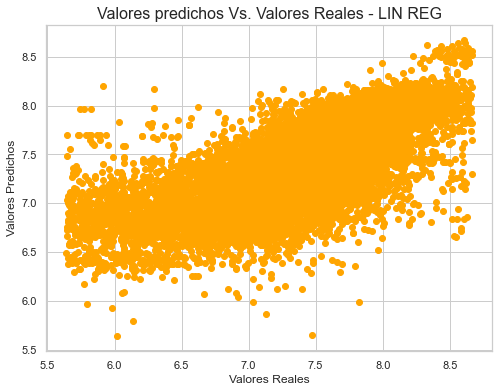

In [72]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y =y_predicted_linear_test, color='orange')
plt.title('Valores predichos Vs. Valores Reales - LIN REG', fontsize=16)
plt.ylabel('Valores Predichos')
plt.xlabel('Valores Reales')

### 9.2 Regresión Lineal (Regularización Ridge)

In [73]:
# Instancio el modelo
ridge_model = linear_model.RidgeCV(cv=5, alphas=np.linspace(1,10,10),
                                   normalize=True)
# Fiteo el modelo
ridge_model_fitted = ridge_model.fit(X_train, y_train)

# Predigo los valores 
y_predicted_ridge_train = ridge_model_fitted.predict(X_train)
y_predicted_ridge_test = ridge_model_fitted.predict(X_test)

# Obtengo el MSE
mse_score_ridge_train = mean_squared_error(y_train, y_predicted_ridge_train)

# Obtengo el score R2
r2_score_ridge_train = ridge_model_fitted.score(X_train, y_train)
r2_score_ridge_test = ridge_model_fitted.score(X_test, y_test)

# Agrego los resultados al dataframe de resultados
row = {'Model':'Ridge', 'MSE': mse_score_ridge_train.mean(), 'R^2': r2_score_ridge_train.mean(), 
       'Alpha': ridge_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}

rowt = {'Model':'Ridge', 'R^2': r2_score_ridge_test.mean(), 
        'Cant. Cols.': len(X_test.columns)}

df_resultados_Train = df_resultados_Train.append(row, ignore_index=True)
df_resultados_Test = df_resultados_Test.append(rowt, ignore_index=True)

# Muestro los resultados
display(df_resultados_Train)
display(df_resultados_Test)


Model           MSE           R^2 Alpha  Cant. Cols.
0  Linear Regression  5.945007e+13 -2.063020e+14     0        695.0
1              Ridge  1.954618e-01  3.302877e-01     4        695.0

Model       R^2  Cant. Cols.
0  Linear Regression  0.544863        695.0
1              Ridge  0.327173        695.0

Text(0.5, 0, 'Valores Reales (con scale)')

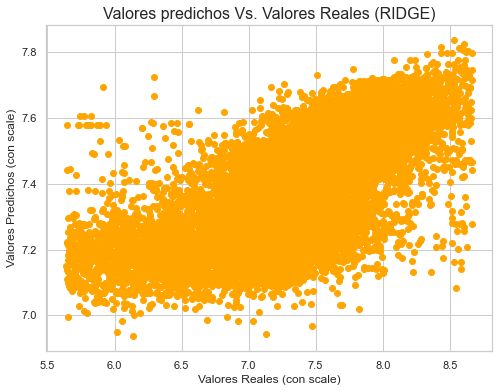

In [74]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y =y_predicted_ridge_test, color='orange')
plt.title('Valores predichos Vs. Valores Reales (RIDGE)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

### 9.3 Regresión Lineal (Regularización Lasso)

In [75]:
# Instancio el modelo
lasso_model = linear_model.LassoCV(cv=5, max_iter=2000, alphas=np.linspace(0.00001,0.0001,100),
                                   normalize=True)
# Fiteo el modelo
lasso_model_fitted = lasso_model.fit(X_train, y_train)

# Predigo los valores 
y_predicted_lasso_train = lasso_model_fitted.predict(X_train)
y_predicted_lasso_test = lasso_model_fitted.predict(X_test)

# Obtengo el MSE
mse_score_lasso_train = mean_squared_error(y_train, y_predicted_lasso_train)

# Obtengo el score R2
r2_score_lasso_train = lasso_model_fitted.score(X_train, y_train)
r2_score_lasso_test = lasso_model_fitted.score(X_test, y_test)

# Agrego los resultados al dataframe de resultados
row = {'Model':'Lasso', 'MSE': mse_score_lasso_train.mean(), 'R^2': r2_score_lasso_train.mean(), 
       'Alpha': lasso_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}

rowt = {'Model':'Lasso', 'R^2': r2_score_lasso_test.mean(), 
        'Cant. Cols.': len(X_test.columns)}

df_resultados_Train = df_resultados_Train.append(row, ignore_index=True)
df_resultados_Test = df_resultados_Test.append(rowt, ignore_index=True)

# Muestro los resultados
display(df_resultados_Train)
display(df_resultados_Test)

Model           MSE           R^2   Alpha  Cant. Cols.
0  Linear Regression  5.945007e+13 -2.063020e+14       0        695.0
1              Ridge  1.954618e-01  3.302877e-01       4        695.0
2              Lasso  1.665997e-01  4.291780e-01  0.0001        695.0

Model       R^2  Cant. Cols.
0  Linear Regression  0.544863        695.0
1              Ridge  0.327173        695.0
2              Lasso  0.428269        695.0

Text(0.5, 0, 'Valores Reales (con scale)')

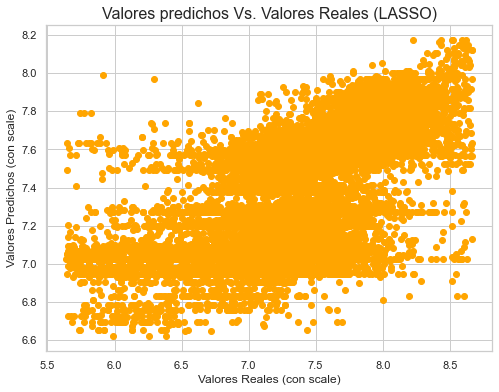

In [76]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y =y_predicted_lasso_test, color='orange')
plt.title('Valores predichos Vs. Valores Reales (LASSO)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

**Graficamos los coeficientes que quedaron luego de la regularización LASSO**

Filtramos las features que tienen coeficientes diferentes de cero, luego de haber aplicado
la regularización Lasso, veremos cuántas quedaron (positivas o negativas) y las graficaremos para observar cómo influyen en el modelo.

In [77]:
coef_dif_0 = lasso_model_fitted.coef_ !=0  # Coef difefentes de cero
filtro = X_test.columns[coef_dif_0] # Columnas diferentes de cero
valores = lasso_model_fitted.coef_[coef_dif_0] #Valores de Coef diferentes de cero
print('Cantidad de Variables luego de Lasso: ', len(filtro))

Cantidad de Variables luego de Lasso:  32


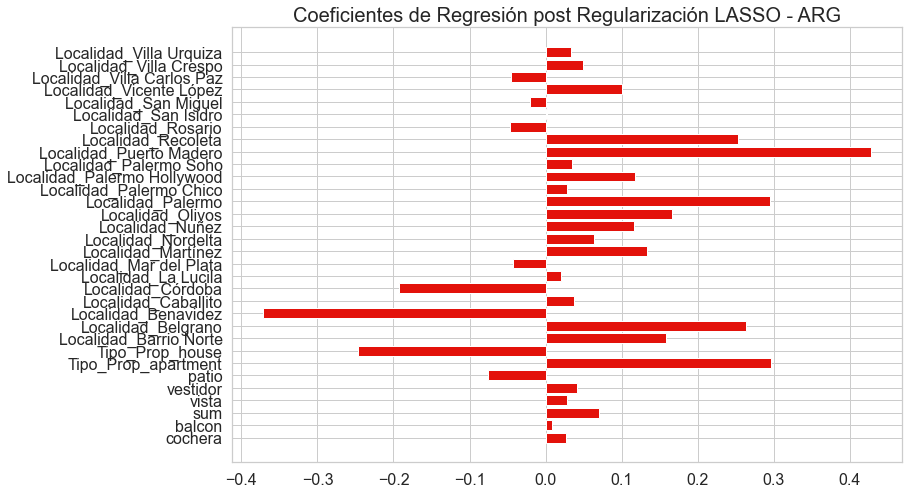

In [78]:

# CREAMOS EL GRÁFICO
y_pos = np.arange(len(filtro))

plt.figure(figsize=(12,8))
# Create horizontal bars
plt.barh(y_pos, valores, color="#E3120B")
plt.title('Coeficientes de Regresión post Regularización LASSO - ARG', fontsize=20)

 
# Create names on the y-axis
plt.yticks(y_pos, filtro, fontsize=16)
plt.xticks(fontsize=16) 
# Show graphic
plt.show()

### 9.4 DataFrame y Graficos Resumen con los Resultados

In [79]:
#  Me guardo los indices originales para poder identificar luego cada fila
y_index = y_test.index
# Reinicio los indices para poder unir los Y de tes ty los Y predichos
y_test_indexless = y_test.reset_index(drop=True)

# Concateno los Y de todos los modelos
y_values = pd.DataFrame({'y_real': y_test_indexless, 'y_linear': y_predicted_linear_test ,
                         'y_ridge':y_predicted_ridge_test, 'y_lasso': y_predicted_lasso_test})

In [80]:
# Elimino los outliers de los valores predichos de cada modelo
df_result_sin_outliers_lasso = y_values[np.abs(y_values['y_lasso']-y_values['y_lasso'].mean())<=(3*y_values['y_lasso'].std())].copy()
df_result_sin_outliers_ridge = y_values[np.abs(y_values['y_ridge']-y_values['y_ridge'].mean())<=(3*y_values['y_ridge'].std())].copy()
df_result_sin_outliers_linear = y_values[np.abs(y_values['y_linear']-y_values['y_linear'].mean())<=(3*y_values['y_linear'].std())].copy()

# Por ultimo agrego una nueva columna con la diferencia entre lo predicho y lo real
df_result_sin_outliers_lasso['result_dif'] = df_result_sin_outliers_lasso['y_real']-df_result_sin_outliers_lasso['y_lasso']
df_result_sin_outliers_ridge['result_dif'] = df_result_sin_outliers_ridge['y_real']-df_result_sin_outliers_ridge['y_ridge']
df_result_sin_outliers_linear['result_dif'] = df_result_sin_outliers_linear['y_real']-df_result_sin_outliers_linear['y_linear']

In [81]:
display(df_result_sin_outliers_linear)
display(df_result_sin_outliers_ridge)
display(df_result_sin_outliers_lasso)

y_real  y_linear   y_ridge   y_lasso  result_dif
0      7.205007  7.353385  7.385446  7.299601   -0.148378
1      7.498424  7.147310  7.286289  7.272684    0.351114
2      6.802395  7.358033  7.246604  7.094279   -0.555639
3      7.526794  7.351583  7.302905  7.159933    0.175211
4      6.002462  7.144887  7.251364  7.025570   -1.142425
...         ...       ...       ...       ...         ...
18725  8.229511  7.857830  7.603969  7.708589    0.371681
18726  7.593522  7.279741  7.455371  7.385594    0.313781
18727  7.013116  6.762951  7.257945  7.301264    0.250165
18728  6.663558  7.085023  7.257143  7.123353   -0.421465
18729  7.555292  7.567309  7.517168  7.595076   -0.012017

[18708 rows x 5 columns]

y_real  y_linear   y_ridge   y_lasso  result_dif
0      7.205007  7.353385  7.385446  7.299601   -0.180439
1      7.498424  7.147310  7.286289  7.272684    0.212135
2      6.802395  7.358033  7.246604  7.094279   -0.444209
3      7.526794  7.351583  7.302905  7.159933    0.223890
4      6.002462  7.144887  7.251364  7.025570   -1.248902
...         ...       ...       ...       ...         ...
18725  8.229511  7.857830  7.603969  7.708589    0.625542
18726  7.593522  7.279741  7.455371  7.385594    0.138151
18727  7.013116  6.762951  7.257945  7.301264   -0.244829
18728  6.663558  7.085023  7.257143  7.123353   -0.593584
18729  7.555292  7.567309  7.517168  7.595076    0.038124

[18730 rows x 5 columns]

y_real  y_linear   y_ridge   y_lasso  result_dif
0      7.205007  7.353385  7.385446  7.299601   -0.094594
1      7.498424  7.147310  7.286289  7.272684    0.225740
2      6.802395  7.358033  7.246604  7.094279   -0.291884
3      7.526794  7.351583  7.302905  7.159933    0.366861
4      6.002462  7.144887  7.251364  7.025570   -1.023108
...         ...       ...       ...       ...         ...
18725  8.229511  7.857830  7.603969  7.708589    0.520922
18726  7.593522  7.279741  7.455371  7.385594    0.207928
18727  7.013116  6.762951  7.257945  7.301264   -0.288148
18728  6.663558  7.085023  7.257143  7.123353   -0.459795
18729  7.555292  7.567309  7.517168  7.595076   -0.039784

[18730 rows x 5 columns]

Text(0.5, 0, 'Valores Reales')

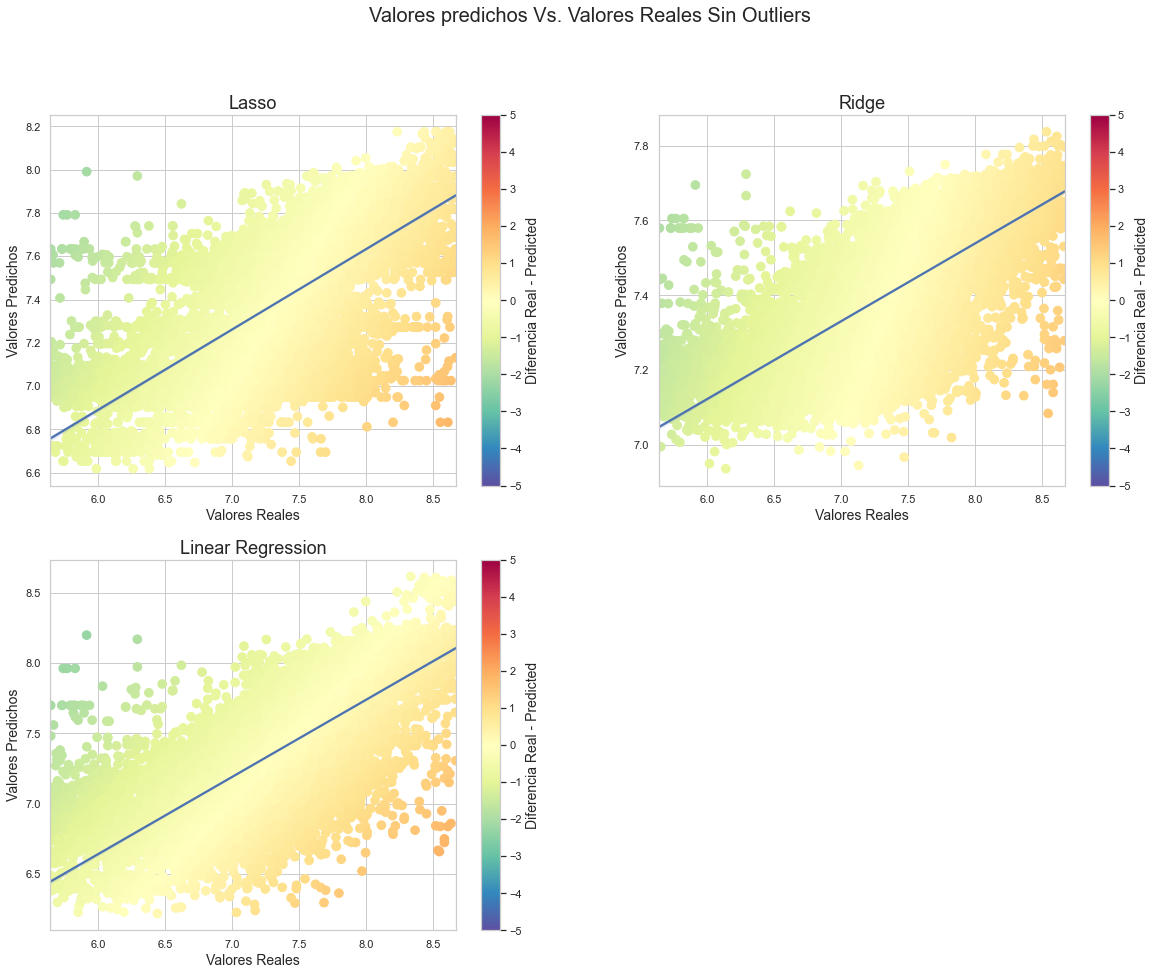

In [82]:
# Ploteo los valores de y sin outliers
plt.figure(figsize=(20,15))

# Defino los ticks con los valores de las colorbar
colorbar_ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

# LASSO
plt.subplot(2,2,1)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_lasso['y_real'], y=df_result_sin_outliers_lasso['y_lasso'],
                     c=df_result_sin_outliers_lasso['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
ax1 = sns.regplot(x="y_real", y="y_lasso", data=df_result_sin_outliers_lasso, scatter=False,)
# Establezco los títulos
plt.title('Lasso', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# RIDGE
plt.subplot(2,2,2)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_ridge['y_real'], y=df_result_sin_outliers_ridge['y_ridge'],
                     c=df_result_sin_outliers_ridge['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_ridge", data=df_result_sin_outliers_ridge, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales', fontsize=20)
plt.title('Ridge', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# LINEAR
plt.subplot(2,2,3)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_linear['y_real'], y=df_result_sin_outliers_linear['y_linear'],
                     c=df_result_sin_outliers_linear['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_linear", data=df_result_sin_outliers_linear, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales Sin Outliers', fontsize=20)
plt.title('Linear Regression', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

<a id="section_resumen_resultados_caba"></a> 
### 10. REGRESION LINEAL PARA EL MODELO OBTENIDO - RESUMEN DE RESULTADOS (CABA)

### 10.1 DataFrame y Graficos Resumen con los Resultados en CABA

In [83]:
df_1

Tipo_Prop        Localidad                     Provincia  Id_Localidad  \
0             PH        Mataderos               Capital Federal     3430787.0   
1      apartment        Mataderos               Capital Federal     3430787.0   
2      apartment           Centro  Buenos Aires Costa Atlántica     3435548.0   
3             PH            Munro      Bs.As. G.B.A. Zona Norte     3430511.0   
4      apartment         Belgrano               Capital Federal     3436077.0   
...          ...              ...                           ...           ...   
74914  apartment          Córdoba                       Córdoba     3860255.0   
74915      house           Beccar      Bs.As. G.B.A. Zona Norte     3436080.0   
74916  apartment    Villa Urquiza               Capital Federal     3433775.0   
74917  apartment      Plaza Colón  Buenos Aires Costa Atlántica           NaN   
74918  apartment  Capital Federal               Capital Federal     3433955.0   

             lat        lon    Precio  cochera  seguridad  parrilla  pileta  \
0     -34.661824 -58.508839   62000.0        0          0         0       0   
1     -34.652262 -58.522982   72000.0        0          0         0       0   
2     -38.002626 -57.549447   64000.0        0          0         0       0   
3     -34.532957 -58.521782  130000.0        0          0         0       0   
4     -34.559873 -58.443362  138000.0        0          0         0       1   
...          ...        ...       ...      ...        ...       ...     ...   
74914 -32.000000 -64.000000   84518.1        0          1         0       0   
74915 -34.463120 -58.534810  498000.0        0          0         1       1   
74916 -34.570639 -58.475596  131500.0        1          0         1       0   
74917        NaN        NaN   95900.0        0          0         0       0   
74918 -34.600000 -58.450000  129000.0        0          0         0       0   

       terraza  quincho  balcon  estrenar  sum  vista  vestidor  patio  \
0            0        0       0         0    0      0         0      1   
1            0        0       0         0    0      0         0      0   
2            0        0       0         0    0      0         0      0   
3            0        0       0         0    0      0         0      1   
4            0        0       0         1    0      0         0      0   
...        ...      ...     ...       ...  ...    ...       ...    ...   
74914        0        1       1         0    1      1         0      0   
74915        0        1       0         0    0      0         1      0   
74916        1        0       1         1    0      0         0      0   
74917        0        0       0         0    0      0         0      0   
74918        0        0       0         0    0      0         0      0   

       Habitaciones  Sup_Total  Sup_Cubierta  Precio_por_m2  log_Precio  \
0               2.0       55.0          40.0    1127.272727   11.034890   
1               2.0       55.0          55.0    1309.090909   11.184421   
2               2.0       35.0          35.0    1828.571429   11.066638   
3               3.0      106.0          78.0    1226.415094   11.775290   
4               2.0       45.0          40.0    3066.666667   11.835009   
...             ...        ...           ...            ...         ...   
74914           2.0       50.0          50.0    1690.362000   11.344721   
74915           4.0      360.0         360.0    1383.333333   13.118355   
74916           2.0       46.0          39.0    2858.695652   11.786762   
74917           2.0       48.0          48.0    1997.916667   11.471061   
74918           2.0       77.0          77.0    1675.324675   11.767568   

       log_Precio_por_m2  
0               7.027556  
1               7.177088  
2               7.511290  
3               7.111851  
4               8.028346  
...                  ...  
74914           7.432698  
74915           7.232251  
74916           7.958121  
74917           7.599860 

In [84]:
df_caba = df_1.loc[df_1['Provincia'] == 'Capital Federal']

In [85]:
borrar_columna(df_caba, 'Provincia')
borrar_columna(df_caba, 'Id_Localidad')
borrar_columna(df_caba, 'lat')
borrar_columna(df_caba, 'lon')
borrar_columna(df_caba, 'Precio')
borrar_columna(df_caba, 'Sup_Total')
borrar_columna(df_caba, 'Precio_por_m2')
borrar_columna(df_caba, 'log_Precio')

Eliminando columna: Provincia
Lista de columnas eliminadas: ['Unnamed: 0', 'Provincia']
----------------------------------------------------------------------------------------------------
Eliminando columna: Id_Localidad
Lista de columnas eliminadas: ['Unnamed: 0', 'Provincia', 'Id_Localidad']
----------------------------------------------------------------------------------------------------
Eliminando columna: lat
Lista de columnas eliminadas: ['Unnamed: 0', 'Provincia', 'Id_Localidad', 'lat']
----------------------------------------------------------------------------------------------------
Eliminando columna: lon
Lista de columnas eliminadas: ['Unnamed: 0', 'Provincia', 'Id_Localidad', 'lat', 'lon']
----------------------------------------------------------------------------------------------------
Eliminando columna: Precio
Lista de columnas eliminadas: ['Unnamed: 0', 'Provincia', 'Id_Localidad', 'lat', 'lon', 'Precio']
-----------------------------------------------------------

In [86]:
df_caba.reset_index(drop=True, inplace=True)

In [87]:
df_caba.shape

(23925, 17)

### 10.1.2 Regresión Lineal (en CABA)

In [88]:
def obtener_X_y(data, num_features, cat_features, target_feature):
    """La funcion requiere de un DF de pandas, una lista de features numericos, una lista de features categoricos,
    un string de la variable target.
        Devuelve un DF y un Array con las Features y Target respectivamente.
    """
    Xn = data[num_features]
    Xc = data[cat_features]
    y = data[target_feature].reset_index(drop=True)
    Xc = pd.get_dummies(Xc, drop_first=True)
    if 'Habitaciones' in cat_features:
        hab_dumm = pd.get_dummies(data['Habitaciones'], drop_first=True)
        X = pd.concat([Xn, Xc, hab_dumm], axis=1).reset_index(drop=True)
        X.drop('Habitaciones', axis=1, inplace=True)
    else:
        X = pd.concat([Xn, Xc], axis=1).reset_index(drop=True)
    return X, y

In [89]:
num_features = ['Sup_Cubierta']
cat_features = ['Tipo_Prop', 'Localidad', 'cochera', 'seguridad', 'parrilla', 'pileta', 
                'terraza','quincho', 'balcon', 'estrenar', 'sum', 'vista', 'vestidor', 'patio',
               'Habitaciones']
target_feature = 'log_Precio_por_m2'

In [90]:
X, y = obtener_X_y(df_caba, num_features, cat_features, target_feature)

In [91]:
print('Se testearán a los modelos con ',len(X),'registros')

Se testearán a los modelos con  23925 registros


In [92]:
# Instancio el modelo
lin_model = LinearRegression()
# Fiteo el modelo
lin_model_fitted = lin_model.fit(X, y)

# Ejecuto una cross validation de 5 folds
scores_linear = cross_validate(lin_model_fitted, X, y, cv=5,
                       scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

# Predigo los valores 

y_predicted_linear = lin_model_fitted.predict(X)

# Calculo las Métricas

mse_score_linear = np.mean(scores_linear['test_neg_mean_squared_error']*-1)
r2_score_linear = np.mean(scores_linear['test_r2'])



# Dataframe donde muestro los resultados
df_resultados = pd.DataFrame(columns=['Model', 'MSE', 'R^2', 'Alpha'])


# Agrego los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'MSE': mse_score_linear, 'R^2': r2_score_linear, 
       'Alpha': 0, 'Cant. Cols.': len(X.columns)}


df_resultados = df_resultados.append(row, ignore_index=True)


# Muestro los resultados
display(df_resultados)


Model       MSE       R^2 Alpha  Cant. Cols.
0  Linear Regression  1.214191 -9.738231     0         88.0

Text(0.5, 0, 'Valores Reales')

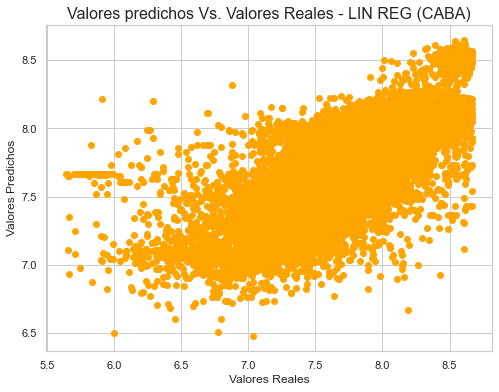

In [93]:
plt.figure(figsize=(8,6))
plt.scatter(x=y, y =y_predicted_linear, color='orange')
plt.title('Valores predichos Vs. Valores Reales - LIN REG (CABA)', fontsize=16)
plt.ylabel('Valores Predichos')
plt.xlabel('Valores Reales')

### 10.1.3 Regresión Lineal (Regularización Ridge en CABA)

In [94]:
# Instancio el modelo
ridge_model = linear_model.RidgeCV(cv=5, alphas=np.linspace(1,10,100),
                                    normalize=True)
# Fiteo el modelo
ridge_model_fitted = ridge_model.fit(X, y)

# Predigo los valores 
y_predicted_ridge = ridge_model_fitted.predict(X)


# Obtengo el MSE
mse_score_ridge = mean_squared_error(y, y_predicted_ridge)

# Obtengo el score R2
r2_score_ridge = ridge_model_fitted.score(X, y)


# Agrego los resultados al dataframe de resultados
row = {'Model':'Ridge', 'MSE': mse_score_ridge.mean(), 'R^2': r2_score_ridge.mean(), 
       'Alpha': ridge_model_fitted.alpha_, 'Cant. Cols.': len(X.columns)}



df_resultados = df_resultados.append(row, ignore_index=True)


# Muestro los resultados
display(df_resultados)


Model       MSE       R^2 Alpha  Cant. Cols.
0  Linear Regression  1.214191 -9.738231     0         88.0
1              Ridge  0.133856  0.149365    10         88.0

Text(0.5, 0, 'Valores Reales (con scale)')

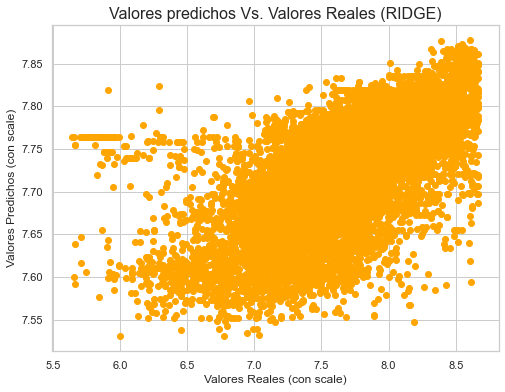

In [95]:
plt.figure(figsize=(8,6))
plt.scatter(x=y, y =y_predicted_ridge, color='orange')
plt.title('Valores predichos Vs. Valores Reales (RIDGE)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

### 10.1.4 Regresión Lineal (Regularización Lasso en CABA)

In [96]:
# Instancio el modelo
lasso_model = linear_model.LassoCV(cv=5, max_iter=2000, alphas=np.linspace(0.00001,0.0001,100),
                                   normalize=True)
# Fiteo el modelo
lasso_model_fitted = lasso_model.fit(X, y)

# Predigo los valores 
y_predicted_lasso = lasso_model_fitted.predict(X)


# Obtengo el MSE
mse_score_lasso = mean_squared_error(y, y_predicted_lasso)

# Obtengo el score R2
r2_score_lasso = lasso_model_fitted.score(X, y)


# Agrego los resultados al dataframe de resultados
row = {'Model':'Lasso', 'MSE': mse_score_lasso.mean(), 'R^2': r2_score_lasso.mean(), 
       'Alpha': lasso_model_fitted.alpha_, 'Cant. Cols.': len(X.columns)}

rowt = {'Model':'Lasso', 'R^2': r2_score_lasso_test.mean(), 
        'Cant. Cols.': len(X_test.columns)}

df_resultados = df_resultados.append(row, ignore_index=True)


# Muestro los resultados
display(df_resultados)


Model       MSE       R^2   Alpha  Cant. Cols.
0  Linear Regression  1.214191 -9.738231       0         88.0
1              Ridge  0.133856  0.149365      10         88.0
2              Lasso  0.089863  0.428936  0.0001         88.0

Text(0.5, 0, 'Valores Reales (con scale)')

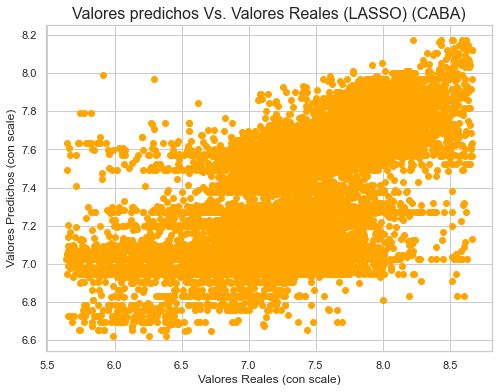

In [97]:
plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y =y_predicted_lasso_test, color='orange')
plt.title('Valores predichos Vs. Valores Reales (LASSO) (CABA)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

In [98]:
coef_dif_0 = lasso_model_fitted.coef_ !=0  # Coef difefentes de cero
filtro = X.columns[coef_dif_0] # Columnas diferentes de cero
valores = lasso_model_fitted.coef_[coef_dif_0] #Valores de Coef diferentes de cero
print('Cantidad de Variables luego de Lasso: ', len(filtro))

Cantidad de Variables luego de Lasso:  37


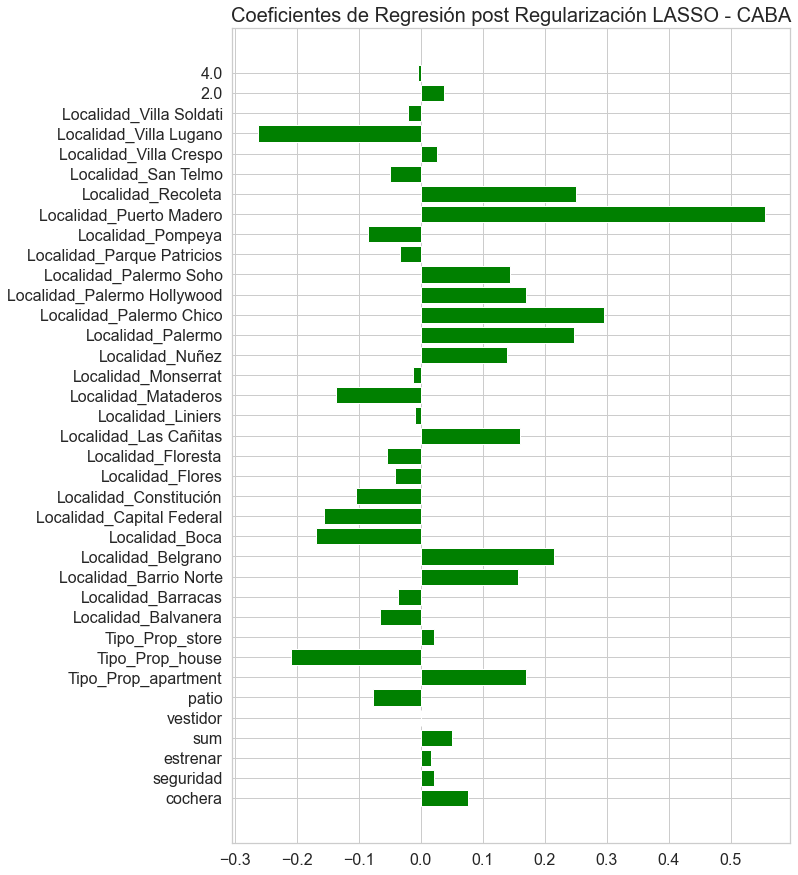

In [99]:
coef_dif_0 = lasso_model_fitted.coef_ !=0  # Coef difefentes de cero
filtro = X.columns[coef_dif_0] # Columnas diferentes de cero
valores = lasso_model_fitted.coef_[coef_dif_0] #Valores de Coef diferentes de cero


# CREAMOS EL GRÁFICO
y_pos = np.arange(len(filtro))

plt.figure(figsize=(10,15))
# Create horizontal bars
plt.barh(y_pos, valores, color="green")
plt.title('Coeficientes de Regresión post Regularización LASSO - CABA', fontsize=20)

 
# Create names on the y-axis
plt.yticks(y_pos, filtro, fontsize=16)
plt.xticks(fontsize=16) 
# Show graphic
plt.show()

### 10.2 DataFrame y Graficos Resumen con los Resultados

In [100]:
#  Me guardo los indices originales para poder identificar luego cada fila
y_index = y.index
# Reinicio los indices para poder unir los Y de tes ty los Y predichos
y_indexless = y.reset_index(drop=True)

# Concateno los Y de todos los modelos
y_values = pd.DataFrame({'y_real': y_indexless, 'y_linear': y_predicted_linear ,
                         'y_ridge':y_predicted_ridge, 'y_lasso': y_predicted_lasso})

In [101]:
y_values

y_real  y_linear   y_ridge   y_lasso
0      7.027556  7.197413  7.646312  7.328114
1      7.177088  7.435916  7.701747  7.574652
2      8.028346  8.031618  7.781805  7.942998
3      8.006368  8.031578  7.781798  7.942998
4      7.711549  7.911842  7.759864  7.818181
...         ...       ...       ...       ...
23920  8.122199  8.083631  7.792500  8.053531
23921  8.229511  8.078273  7.781307  7.962589
23922  7.867667  7.990358  7.784958  7.926181
23923  7.958121  7.894498  7.776973  7.804900
23924  7.423762  7.432820  7.706177  7.555412

[23925 rows x 4 columns]

In [102]:
# Elimino los outliers de los valores predichos de cada modelo
df_result_sin_outliers_lasso = y_values[np.abs(y_values['y_lasso']-y_values['y_lasso'].mean())<=(3*y_values['y_lasso'].std())].copy()
df_result_sin_outliers_ridge = y_values[np.abs(y_values['y_ridge']-y_values['y_ridge'].mean())<=(3*y_values['y_ridge'].std())].copy()
df_result_sin_outliers_linear = y_values[np.abs(y_values['y_linear']-y_values['y_linear'].mean())<=(3*y_values['y_linear'].std())].copy()

# Por ultimo agrego una nueva columna con la diferencia entre lo predicho y lo real
df_result_sin_outliers_lasso['result_dif'] = df_result_sin_outliers_lasso['y_real']-df_result_sin_outliers_lasso['y_lasso']
df_result_sin_outliers_ridge['result_dif'] = df_result_sin_outliers_ridge['y_real']-df_result_sin_outliers_ridge['y_ridge']
df_result_sin_outliers_linear['result_dif'] = df_result_sin_outliers_linear['y_real']-df_result_sin_outliers_linear['y_linear']

Text(0.5, 0, 'Valores Reales')

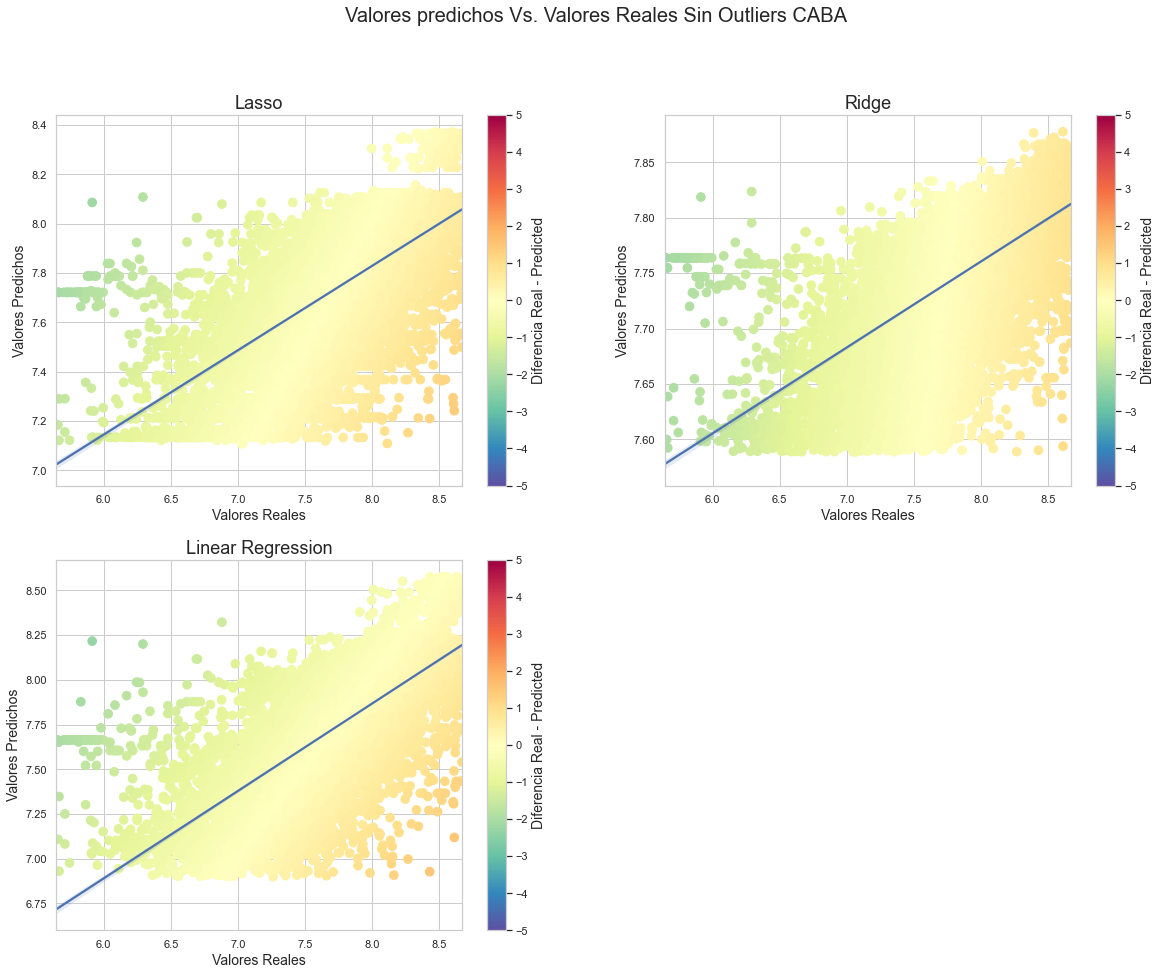

In [103]:
# Ploteo los valores de y sin outliers
plt.figure(figsize=(20,15))

# Defino los ticks con los valores de las colorbar
colorbar_ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

# LASSO
plt.subplot(2,2,1)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_lasso['y_real'], y=df_result_sin_outliers_lasso['y_lasso'],
                     c=df_result_sin_outliers_lasso['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
ax1 = sns.regplot(x="y_real", y="y_lasso", data=df_result_sin_outliers_lasso, scatter=False,)
# Establezco los títulos
plt.title('Lasso', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# RIDGE
plt.subplot(2,2,2)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_ridge['y_real'], y=df_result_sin_outliers_ridge['y_ridge'],
                     c=df_result_sin_outliers_ridge['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_ridge", data=df_result_sin_outliers_ridge, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales', fontsize=20)
plt.title('Ridge', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# LINEAR
plt.subplot(2,2,3)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_linear['y_real'], y=df_result_sin_outliers_linear['y_linear'],
                     c=df_result_sin_outliers_linear['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_linear", data=df_result_sin_outliers_linear, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales Sin Outliers CABA', fontsize=20)
plt.title('Linear Regression', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

<a id="section_supuestos_markov"></a> 
### 11. ANALISIS DE CONSISTENCIA DEL MODELO. SUPUESTOS DE MARKOV

Bajo ciertas condiciones, conocidas como los supuestos de **Gauss-Markov**, los coeficientes de la regresión son lineales, insesgados y tienen varianza mínima.


### Repaso de los supuestos de Gauss-Markov

1. El modelo es lineal en los parámetros.
2. Los estimadores de los parámetros poblacionales se estiman a partir de una muestra aleatoria.
3. No hay colinealidad perfecta entre las variables explicativas.
4. El valor esperado del error es 0 para cualquier valor de la variable explicativa.
5. Para cualquier valor de la variable explicativa, el error tienen la misma varianza (homocedasticidad).
6. El error es independiente de las variables explicativas y se distribuye normalmente.
$\epsilon \sim N (0,\sigma_\epsilon)$
7. No existe autocorrelación entre los errores de dos observaciones diferentes condicionadas a X.
$Cov(\epsilon_i,\epsilon_h|X)=0$

### 11.1. Linealidad del modelo.
Se supone que la variable dependiente ($y$) es una función lineal de las variables independientes ($X$, "features o características") especificadas en el modelo. La especificación del modelo debe ser lineal en sus parámetros. Ajustar un modelo lineal a datos con patrones no lineales da como resultado graves errores de predicción, especialmente fuera de muestra (datos no utilizados para entrenar el modelo).

Para detectar la falta de linealidad, se pueden inspeccionar gráficas de valores observados frente a valores pronosticados o residuales frente a valores predichos. El resultado deseado es que los puntos se distribuyen simétricamente alrededor de una línea diagonal en la primera gráfica o alrededor de una línea horizontal en la última. En ambos casos con una varianza aproximadamente constante.

Analizaremos como performa el modelo sobre el Set de datos total. 

In [104]:
#df_1.drop(df_1.loc[df_1['Habitaciones'] > 12].index,inplace=True)
#df_1 = df_1.reset_index(drop=True)

In [105]:
df = df_1.copy()

In [106]:
num_features = ['Sup_Cubierta']
cat_features = ['Tipo_Prop', 'Localidad', 'cochera', 'seguridad', 'parrilla', 'pileta', 
                'terraza','quincho', 'balcon', 'estrenar', 'sum', 'vista', 'vestidor', 'patio',
               'Habitaciones']
target_feature = 'log_Precio_por_m2'

In [107]:
df_model_train, df_model_test = get_df_train_df_test(df, num_features, cat_features, target_feature, 
                             test_size=0.25, random_state=120)

In [108]:
y_train = df_model_train['log_Precio_por_m2']
X_train = df_model_train.drop(['log_Precio_por_m2'], axis=1).copy()
y_test = df_model_test['log_Precio_por_m2']
X_test = df_model_test.drop(['log_Precio_por_m2'], axis=1).copy()

In [109]:
print('Se entrenarán a los modelos con ',len(X_train),'registros')
print('Se testearán a los modelos con ',len(X_test),'registros')

Se entrenarán a los modelos con  56189 registros
Se testearán a los modelos con  18730 registros


In [110]:
# Instancio el modelo
lin_model = LinearRegression()
# Fiteo el modelo
lin_model_fitted = lin_model.fit(X_train, y_train)

# Ejecuto una cross validation de 5 folds
scores_linear = cross_validate(lin_model_fitted, X_train, y_train, cv=5,
                       scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)

# Predigo los valores 

y_predicted_linear_test = lin_model_fitted.predict(X_test)

# Calculo las Métricas

mse_score_linear_train = np.mean(scores_linear['train_neg_mean_squared_error']*-1)
r2_score_linear_train = np.mean(scores_linear['train_r2'])
r2_score_linear_test = lin_model_fitted.score(X_test, y_test)


# Dataframe donde muestro los resultados
df_resultados_Train = pd.DataFrame(columns=['Model', 'MSE', 'R^2', 'Alpha'])
df_resultados_Test = pd.DataFrame(columns=['Model', 'R^2'])

# Agrego los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'MSE': mse_score_linear_train, 'R^2': r2_score_linear_train, 
       'Alpha': 0, 'Cant. Cols.': len(X_train.columns)}
rowt = {'Model':'Linear Regression', 'R^2': r2_score_linear_test, 
        'Cant. Cols.': len(X_test.columns)}

df_resultados_Train = df_resultados_Train.append(row, ignore_index=True)
df_resultados_Test = df_resultados_Test.append(rowt, ignore_index=True)

# Muestro los resultados
display(df_resultados_Train)
display(df_resultados_Test)

Model       MSE       R^2 Alpha  Cant. Cols.
0  Linear Regression  0.126982  0.564911     0        695.0

Model       R^2  Cant. Cols.
0  Linear Regression  0.544863        695.0

In [111]:
residuals = y_test - y_predicted_linear_test

Text(0.5, 0.98, 'Caracterización de Errores')

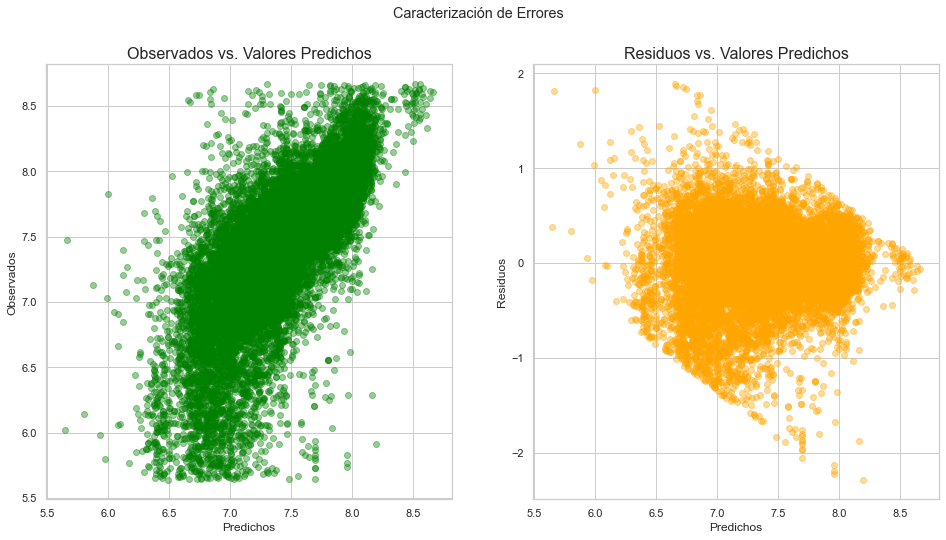

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(y_predicted_linear_test, y_test, color='green', alpha=0.4)
axs[1].scatter(y_predicted_linear_test, residuals, color='orange', alpha=0.4)
axs[0].set_title('Observados vs. Valores Predichos', fontsize=16)
axs[0].set(xlabel='Predichos', ylabel='Observados')
axs[1].set_title('Residuos vs. Valores Predichos', fontsize=16)
axs[1].set(xlabel='Predichos', ylabel='Residuos')
fig.suptitle('Caracterización de Errores')

**Podemos decir que aproximadamente SÍ se cumple el Supuesto 1 de Linealidad de Markov.**

### 11.2. Esperanza de los residuos igual a cero.
Se supone que la variable dependiente ($y$) es una función lineal de las variables independientes ($X$, "features o características") especificadas en el modelo. La especificación del modelo debe ser lineal en sus parámetros. Ajustar un modelo lineal a datos con patrones no lineales da como resultado graves errores de predicción, especialmente fuera de muestra (datos no utilizados para entrenar el modelo).

Para detectar la falta de linealidad, se pueden inspeccionar gráficas de valores observados frente a valores pronosticados o residuales frente a valores predichos. El resultado deseado es que los puntos se distribuyen simétricamente alrededor de una línea diagonal en la primera gráfica o alrededor de una línea horizontal en la última. En ambos casos con una varianza aproximadamente constante.

In [113]:
residuals.mean()

0.0008143435126402381

**Se cumple el Supuesto 2 de Markov de Esperanza de los Residuos=0.**

### 11.3 Homocedasticidad (varianza igual) de residuos.
Cuando los residuos no tienen una varianza constante (exhiben heterocedasticidad), es difícil determinar la verdadera desviación estándar de los errores de pronóstico.
Para investigar si los residuos presentan igual varianza, podemos observar una gráfica de los residuos (o residuos estandarizados) frente a los valores predichos (ajustados) como hicimos en la figura anterior cuando chequeabamos la linealidad del modelo.
También podemos usar dos pruebas estadísticas: Breusch-Pagan y Goldfeld-Quandt. En ambos, la hipótesis nula supone la homocedasticidad y un valor p por debajo de cierto nivel (como 0.05) indica que debemos rechazar el nulo a favor de la heterocedasticidad.

Text(0.5, 0.98, 'Homocedasticidad')

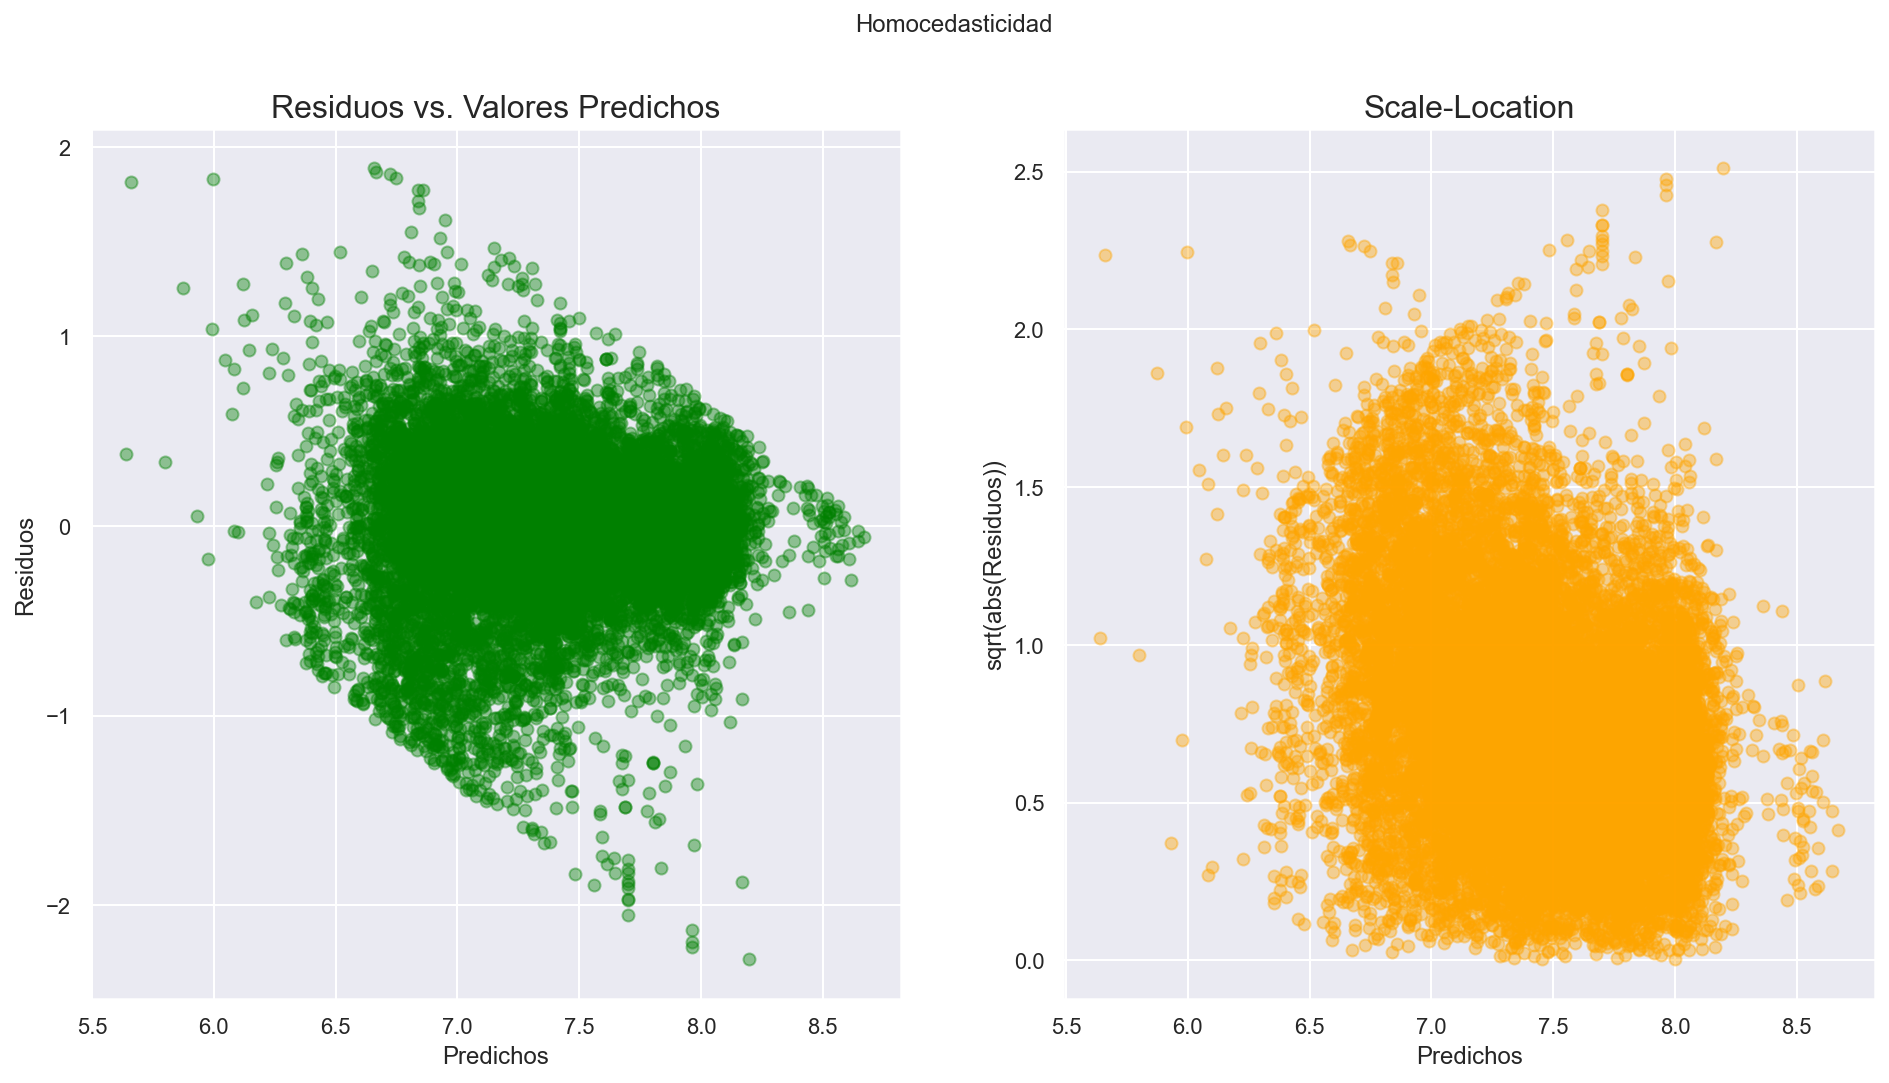

In [114]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

import numpy as np
fitted_vals = y_predicted_linear_test
resids = residuals
resids_standardized = (resids- resids.mean())/ resids.std()
        
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(y_predicted_linear_test, resids, color='green', alpha=0.4)
axs[1].scatter(y_predicted_linear_test, np.sqrt(np.abs(resids_standardized)), color='orange', alpha=0.4)          
axs[0].set_title('Residuos vs. Valores Predichos', fontsize=16)
axs[0].set(xlabel='Predichos', ylabel='Residuos')
axs[1].set_title('Scale-Location', fontsize=16)
axs[1].set(xlabel='Predichos', ylabel='sqrt(abs(Residuos))') 
fig.suptitle('Homocedasticidad')



**Se cumple aproximadamente el supuesto de homocedasticidad.**

### 11.4 Normalidad de los residuos

Cuando se viola este supuesto , puede causar problemas al calcular los intervalos de confianza y varias pruebas de significancia para los coeficientes. Cuando la distribución del error se aleja significativamente de Gauss, los intervalos de confianza pueden ser demasiado amplios o demasiado estrechos.
Algunas de las posibles razones que causan residuos no normales:
* Presencia de algunos valores atípicos grandes en los datos
* Puede haber otros problemas (violaciones) con los supuestos del modelo
* Otra mejor especificación del modelo podría ser más adecuada para este problema.

Para investigar esta suposición podemos mirar:

* Gráficos QQ de los residuos. Por ejemplo, un patrón de desviaciones en forma de arco de la diagonal implica que los residuos tienen una inclinación excesiva (es decir, la distribución no es simétrica, con demasiados residuos grandes en una dirección). El patrón de desviaciones en forma de s implica una curtosis excesiva de los residuos: hay demasiados o dos pocos errores grandes en ambas direcciones.
*  Pruebas estadísticas como la prueba de Kolmogorov-Smirnov, la prueba de Shapiro-Wilk, la prueba de Jarque-Bera y la prueba de Anderson-Darling pueden ser utiles para evaluar este supuesto.

Jarque-Bera test ---- statistic: 7414.5151, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9580, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.2506, p-value: 0.0000
Anderson-Darling test ---- statistic: 193.0197, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


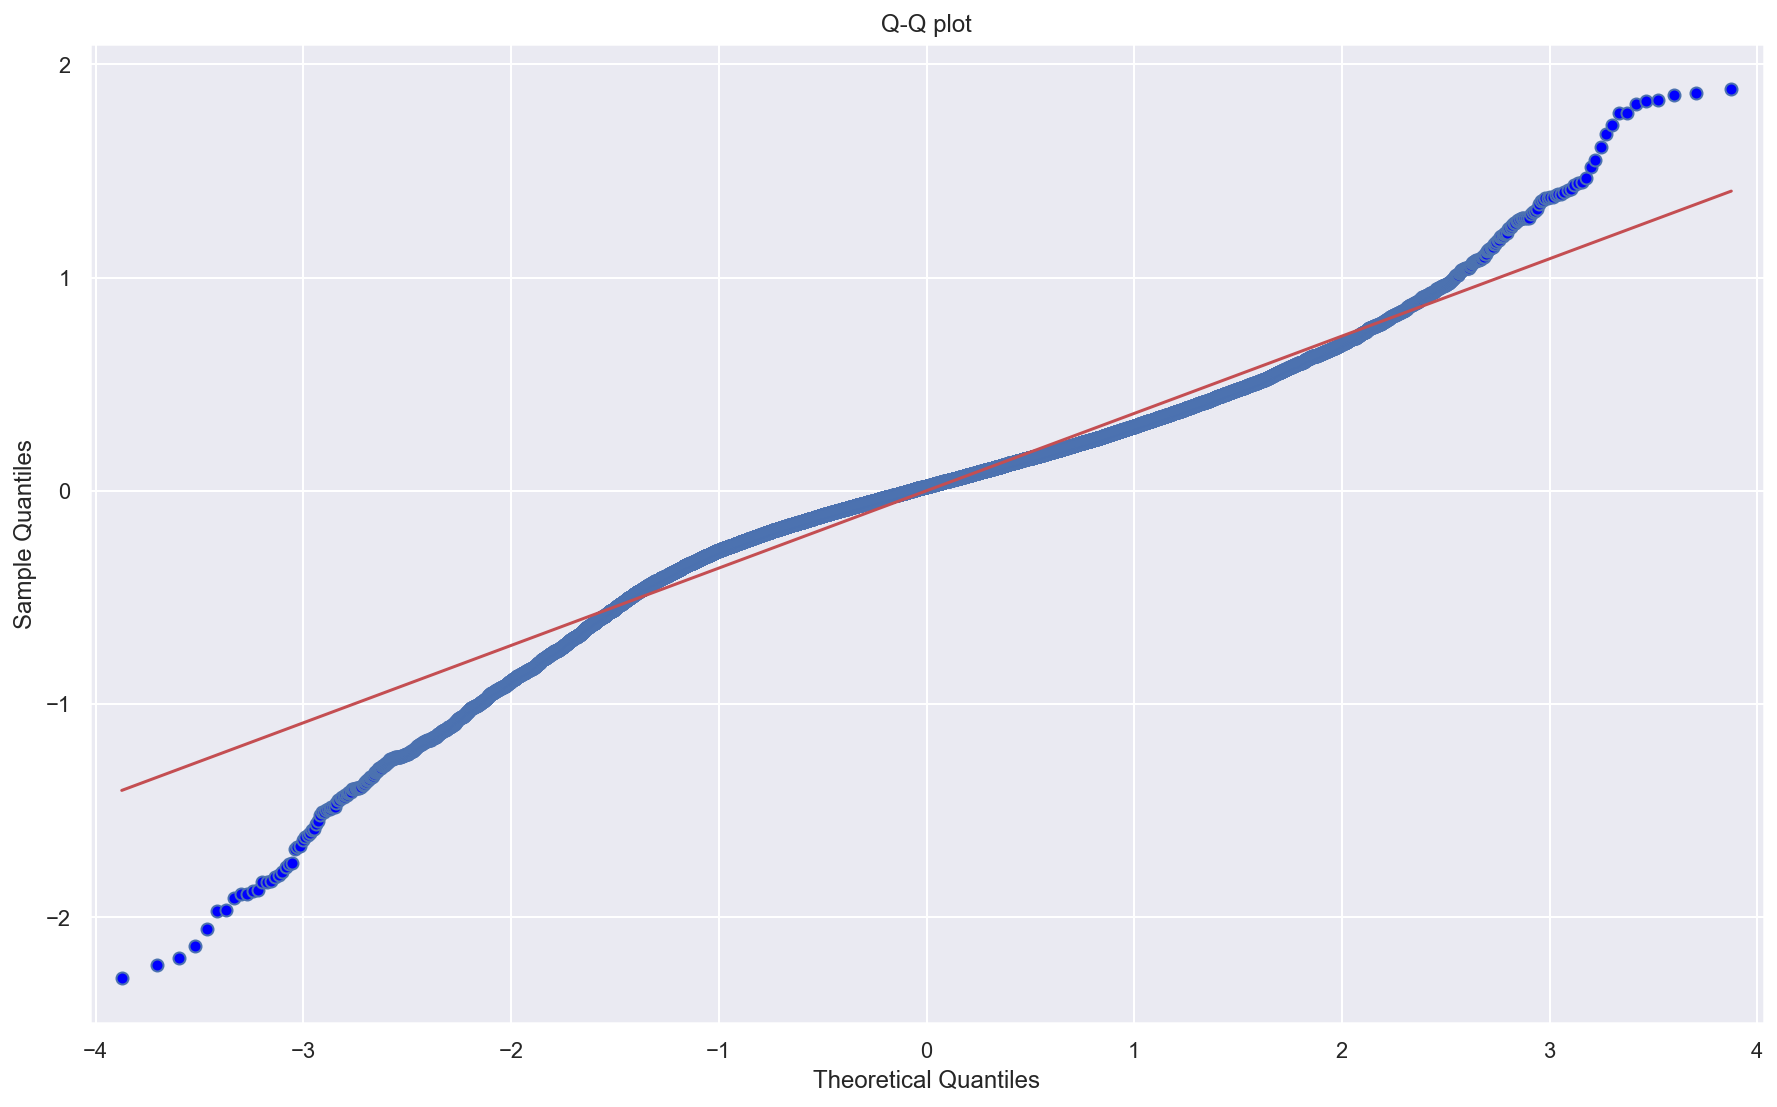

In [115]:
from scipy import stats

sm.ProbPlot(resids).qqplot(line='s');
plt.title('Q-Q plot');

jb = stats.jarque_bera(resids)
sw = stats.shapiro(resids)
ad = stats.anderson(resids, dist='norm')
ks = stats.kstest(resids, 'norm')

print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')



**A partir de los resultados anteriores, podemos inferir siguen una distribución gaussiana, a partir de la forma de la gráfica QQ, excepto en los extremos.**

<a id="section_conclusiones"></a> 
### 12. CONCLUSIONES

***- Gran parte del trabajo estuvo influida por la limpieza del dataset. La misma se realizó de 
manera iterativa, tratando de buscar mayor cantidad de variables descriptivas que aportaran al
modelo de regresión lineal y eliminando outliers y data que no aportan información al mismo.***

***- Los datos podrían ser no del todo precisos, lo cual podría influir en nuestro análisis, introduciendo un cierto sesgo al mismo que no represente del todo a la realidad. Esto se 
refleja en que es necesario un estudio exhaustivo de los mismos, involucrándose y aprendiendo del negocio.***

***- No existe un modelo de regresión lineal único que pueda aplicar, se pueden tratar y plantear diferentes estrategias y escenarios de manera de poder contar con diferentes alternativas de análisis.***

***- Se destaca la importancia de realizar Cross Validation para evaluar el modelo evitando la manipulación de datos del Set de Test o Prueba y el uso de diferentes métricas (MSE, R2) para evaluar su desempeño.***

***- Regularización (Ridge o Lasso) son importantes a la hora de evitar el overfitting. En caso de haber probado el modelo en el Set de Test y haber verificado la no existencia de sobreajuste, la aplicación o no de éstos métodos se evaluarán de un modo criterioso.***

***- Se puede observar la potencia y gran utilidad que poseen librerías tales como StatsModels y Sklearn para trabajos de regresión lineal, así como los métodos gráficos para visualizar errores del modelo y el chequeo de la consistencia del mismo verificando el cumplimiento o no de los Supuestos de Markov.***